In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from src.datasets import daocensus_text
import src.utils.notebooks as nbutils

sns.set_theme()
plt.rcParams['figure.dpi'] = 600

In [2]:
# 'ORG_NAME', 'ORG_PLATFORM', 'SPLITS_FREQ', 'SPLITS_NORMALIZE', 'LAST_SPLITS', 'USE_ORG_NAMES'

ORG_NAME = 'Aave - Aavegotchi'
ORG_PLATFORM = 'snapshot'
USE_ORG_NAMES = True

# Not used
SPLITS_FREQ = ...
SPLITS_NORMALIZE = ...
LAST_SPLITS = ...

In [3]:
# Parameters
ORG_NAME = "Decentraland"
ORG_PLATFORM = "snapshot"
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-01 12s:00"


In [4]:
dfv, dfp = daocensus_text.get('./data/daos-census-text', ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

Warning, removing 116560 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116560 entries, 0 to 116559
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       116560 non-null  object        
 1   name           116560 non-null  object        
 2   id             116560 non-null  object        
 3   proposal       116560 non-null  category      
 4   deployment     116560 non-null  object        
 5   platform_vote  116560 non-null  object        
 6   voter          116560 non-null  category      
 7   date           116560 non-null  datetime64[ns]
 8   choice         116560 non-null  object        
 9   weight         116560 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 8.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 1943 entries, 0f4784fc-022a-5047-8bfe-e16ac3bd0984 to 629184e6-f8b2-5270

# Exploración de datos de Decentraland

In [5]:
print(f"{ORG_NAME} tiene {len(dfv)} votos de {dfv['voter'].nunique()} voters en {dfv['proposal'].nunique()} propuestas")

Decentraland tiene 116560 votos de 7268 voters en 1942 propuestas


In [6]:
dfd = dfp[['platform', 'name', 'platform_deployment']].drop_duplicates()
dfd

platform          name  \
id                                                             
0f4784fc-022a-5047-8bfe-e16ac3bd0984  snapshot  Decentraland   

                                     platform_deployment  
id                                                        
0f4784fc-022a-5047-8bfe-e16ac3bd0984    snapshot.dcl.eth

## Histograma de votos por usuario

7268
197
count    7268.000000
mean       16.037424
std        46.115318
min         1.000000
50%         3.000000
90%        36.000000
95%        64.000000
99%       205.330000
max       885.000000
dtype: float64


Cannot show ipywidgets in text

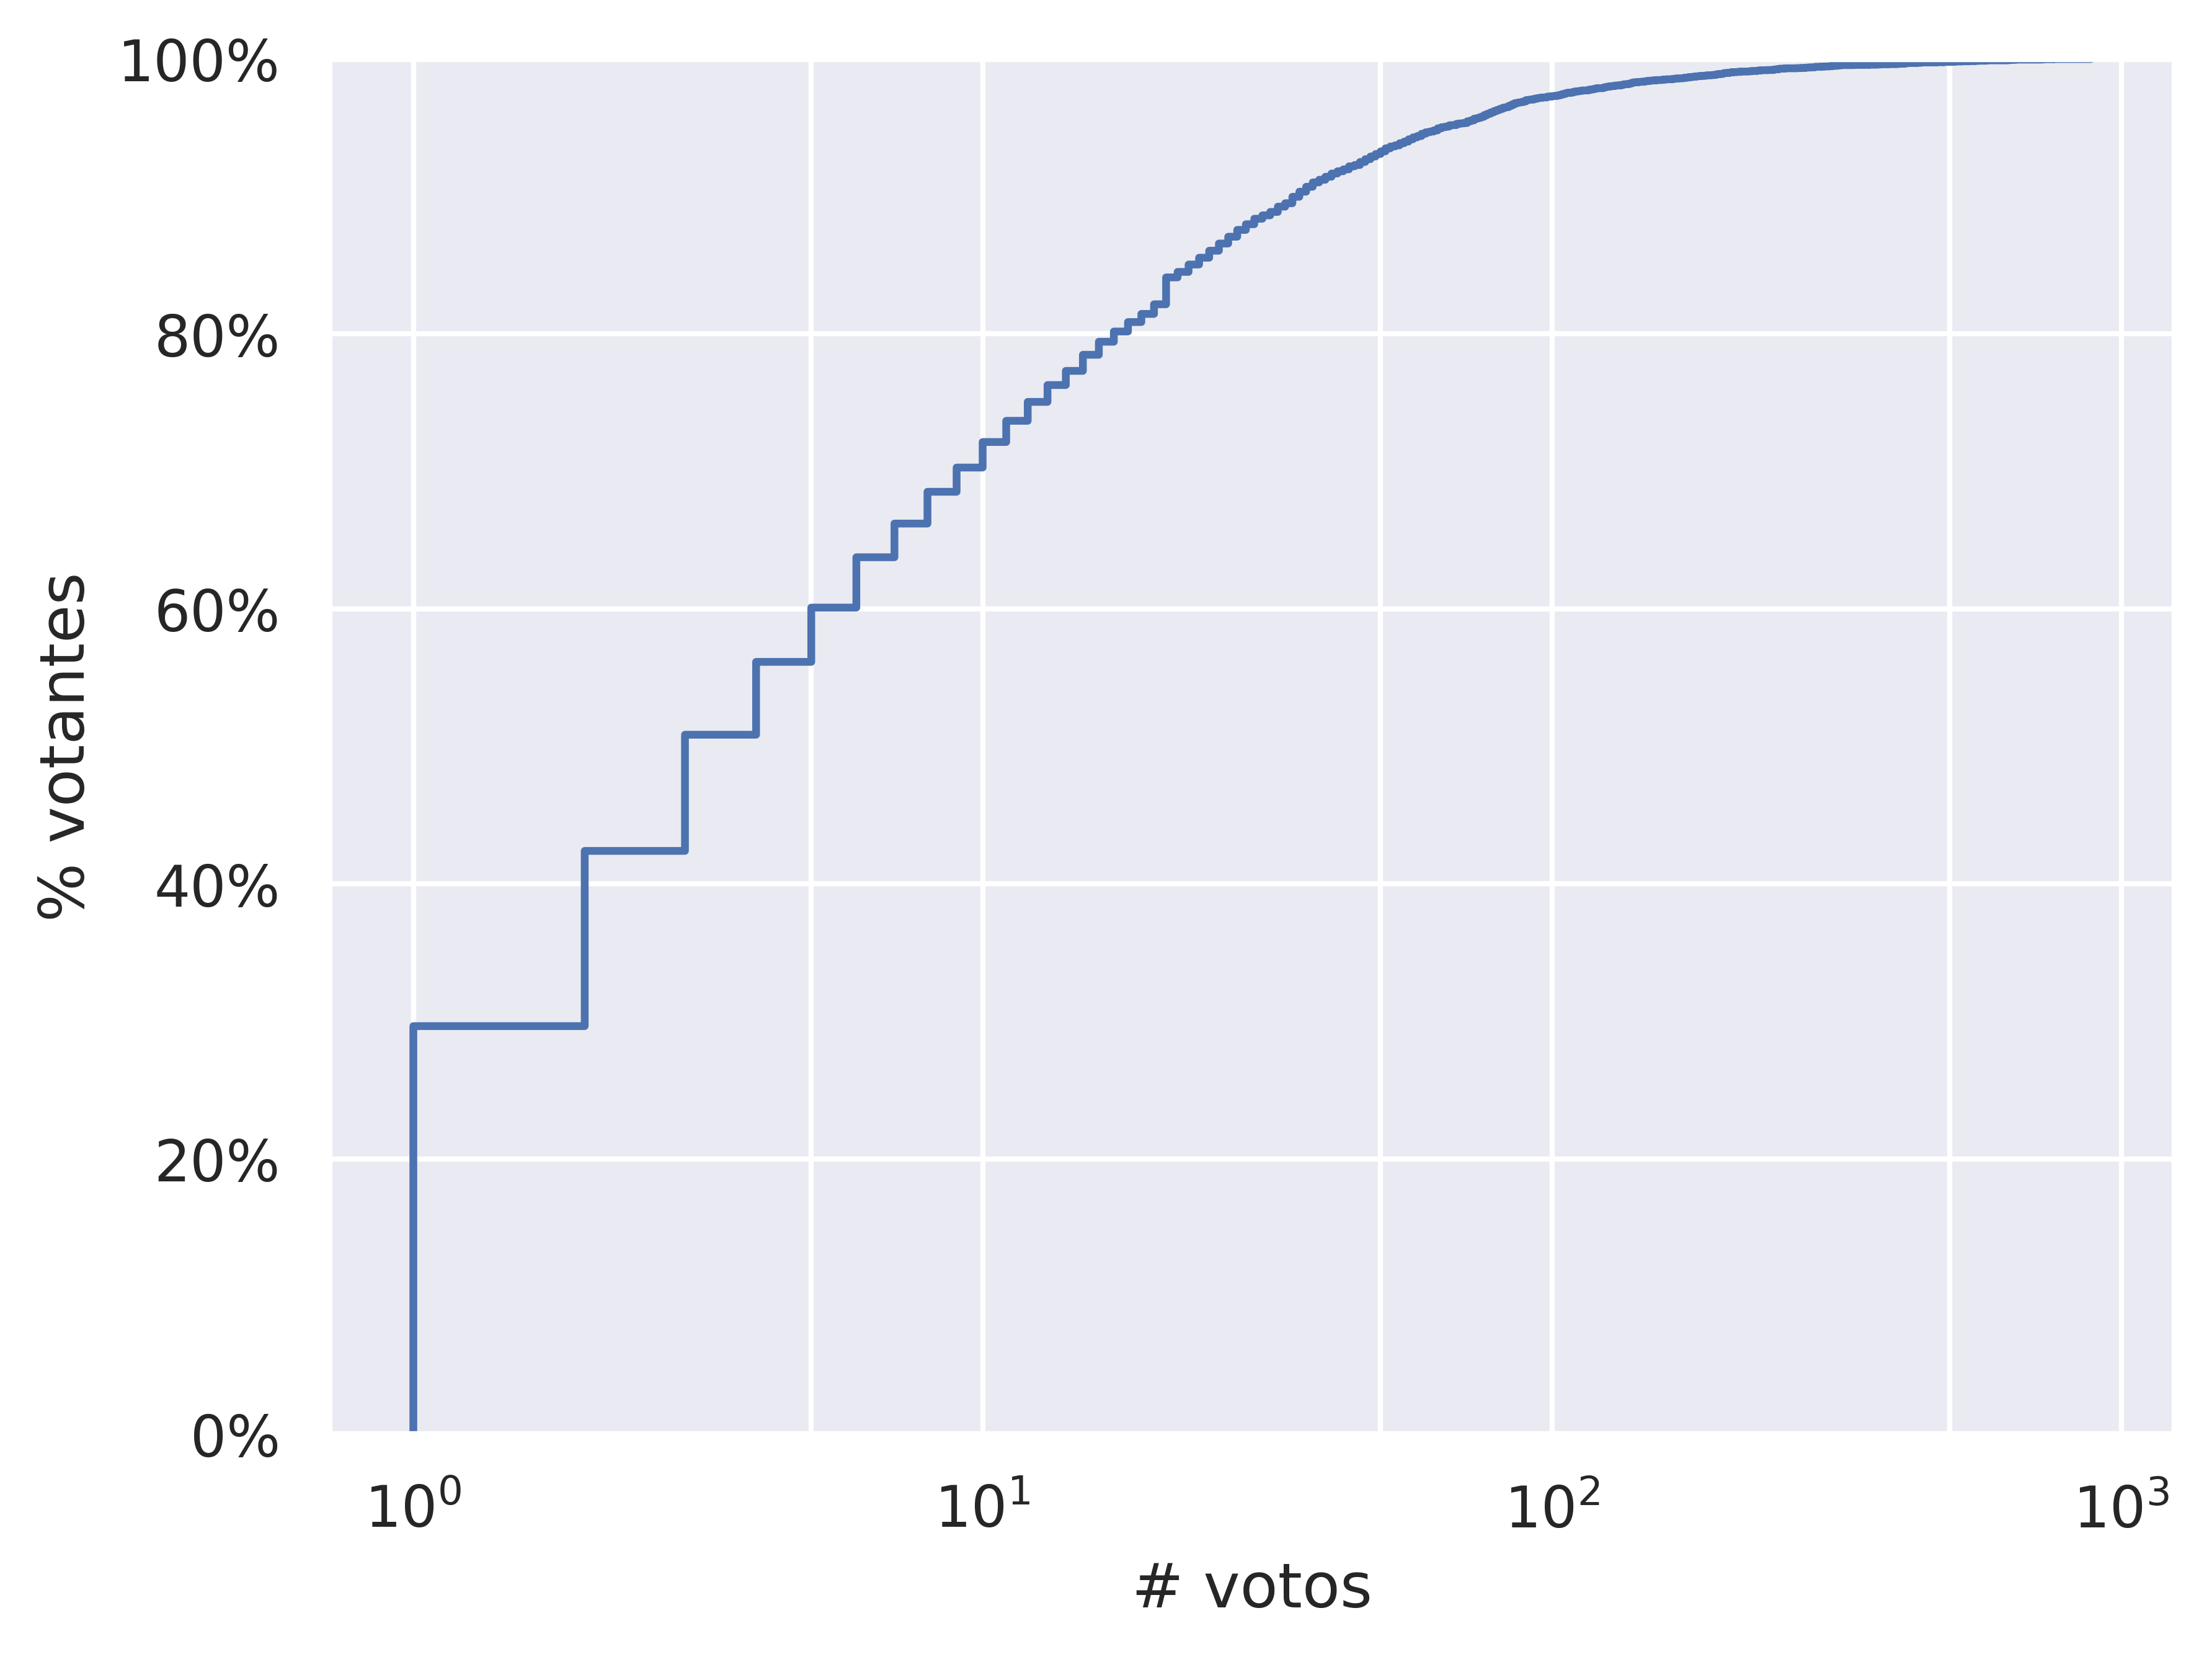

In [7]:
_toplot = dfv.groupby('voter').size()
# _toplot = _toplot[_toplot < 40]
print( len(_toplot) )
print( (_toplot > 100).sum() )
print(_toplot.describe(percentiles=[.5, .9, .95, .99]))
# _toplot.plot.hist(log=True)
ax = sns.ecdfplot(_toplot, log_scale=True)
plt.xlabel('# votos')
plt.ylabel('% votantes')

ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
# ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
nbutils.download_matplotlib(ax.figure, f'04_hybrid_ecdf_voters_{ORG_NAME}.pdf')

## Histograma de votos por propuesta

count    1943.000000
mean       60.057128
std        63.084363
min         1.000000
50%        36.000000
75%        82.000000
90%       146.000000
95%       192.900000
99%       291.320000
max       385.000000
Name: votes_count, dtype: float64
17


Cannot show ipywidgets in text

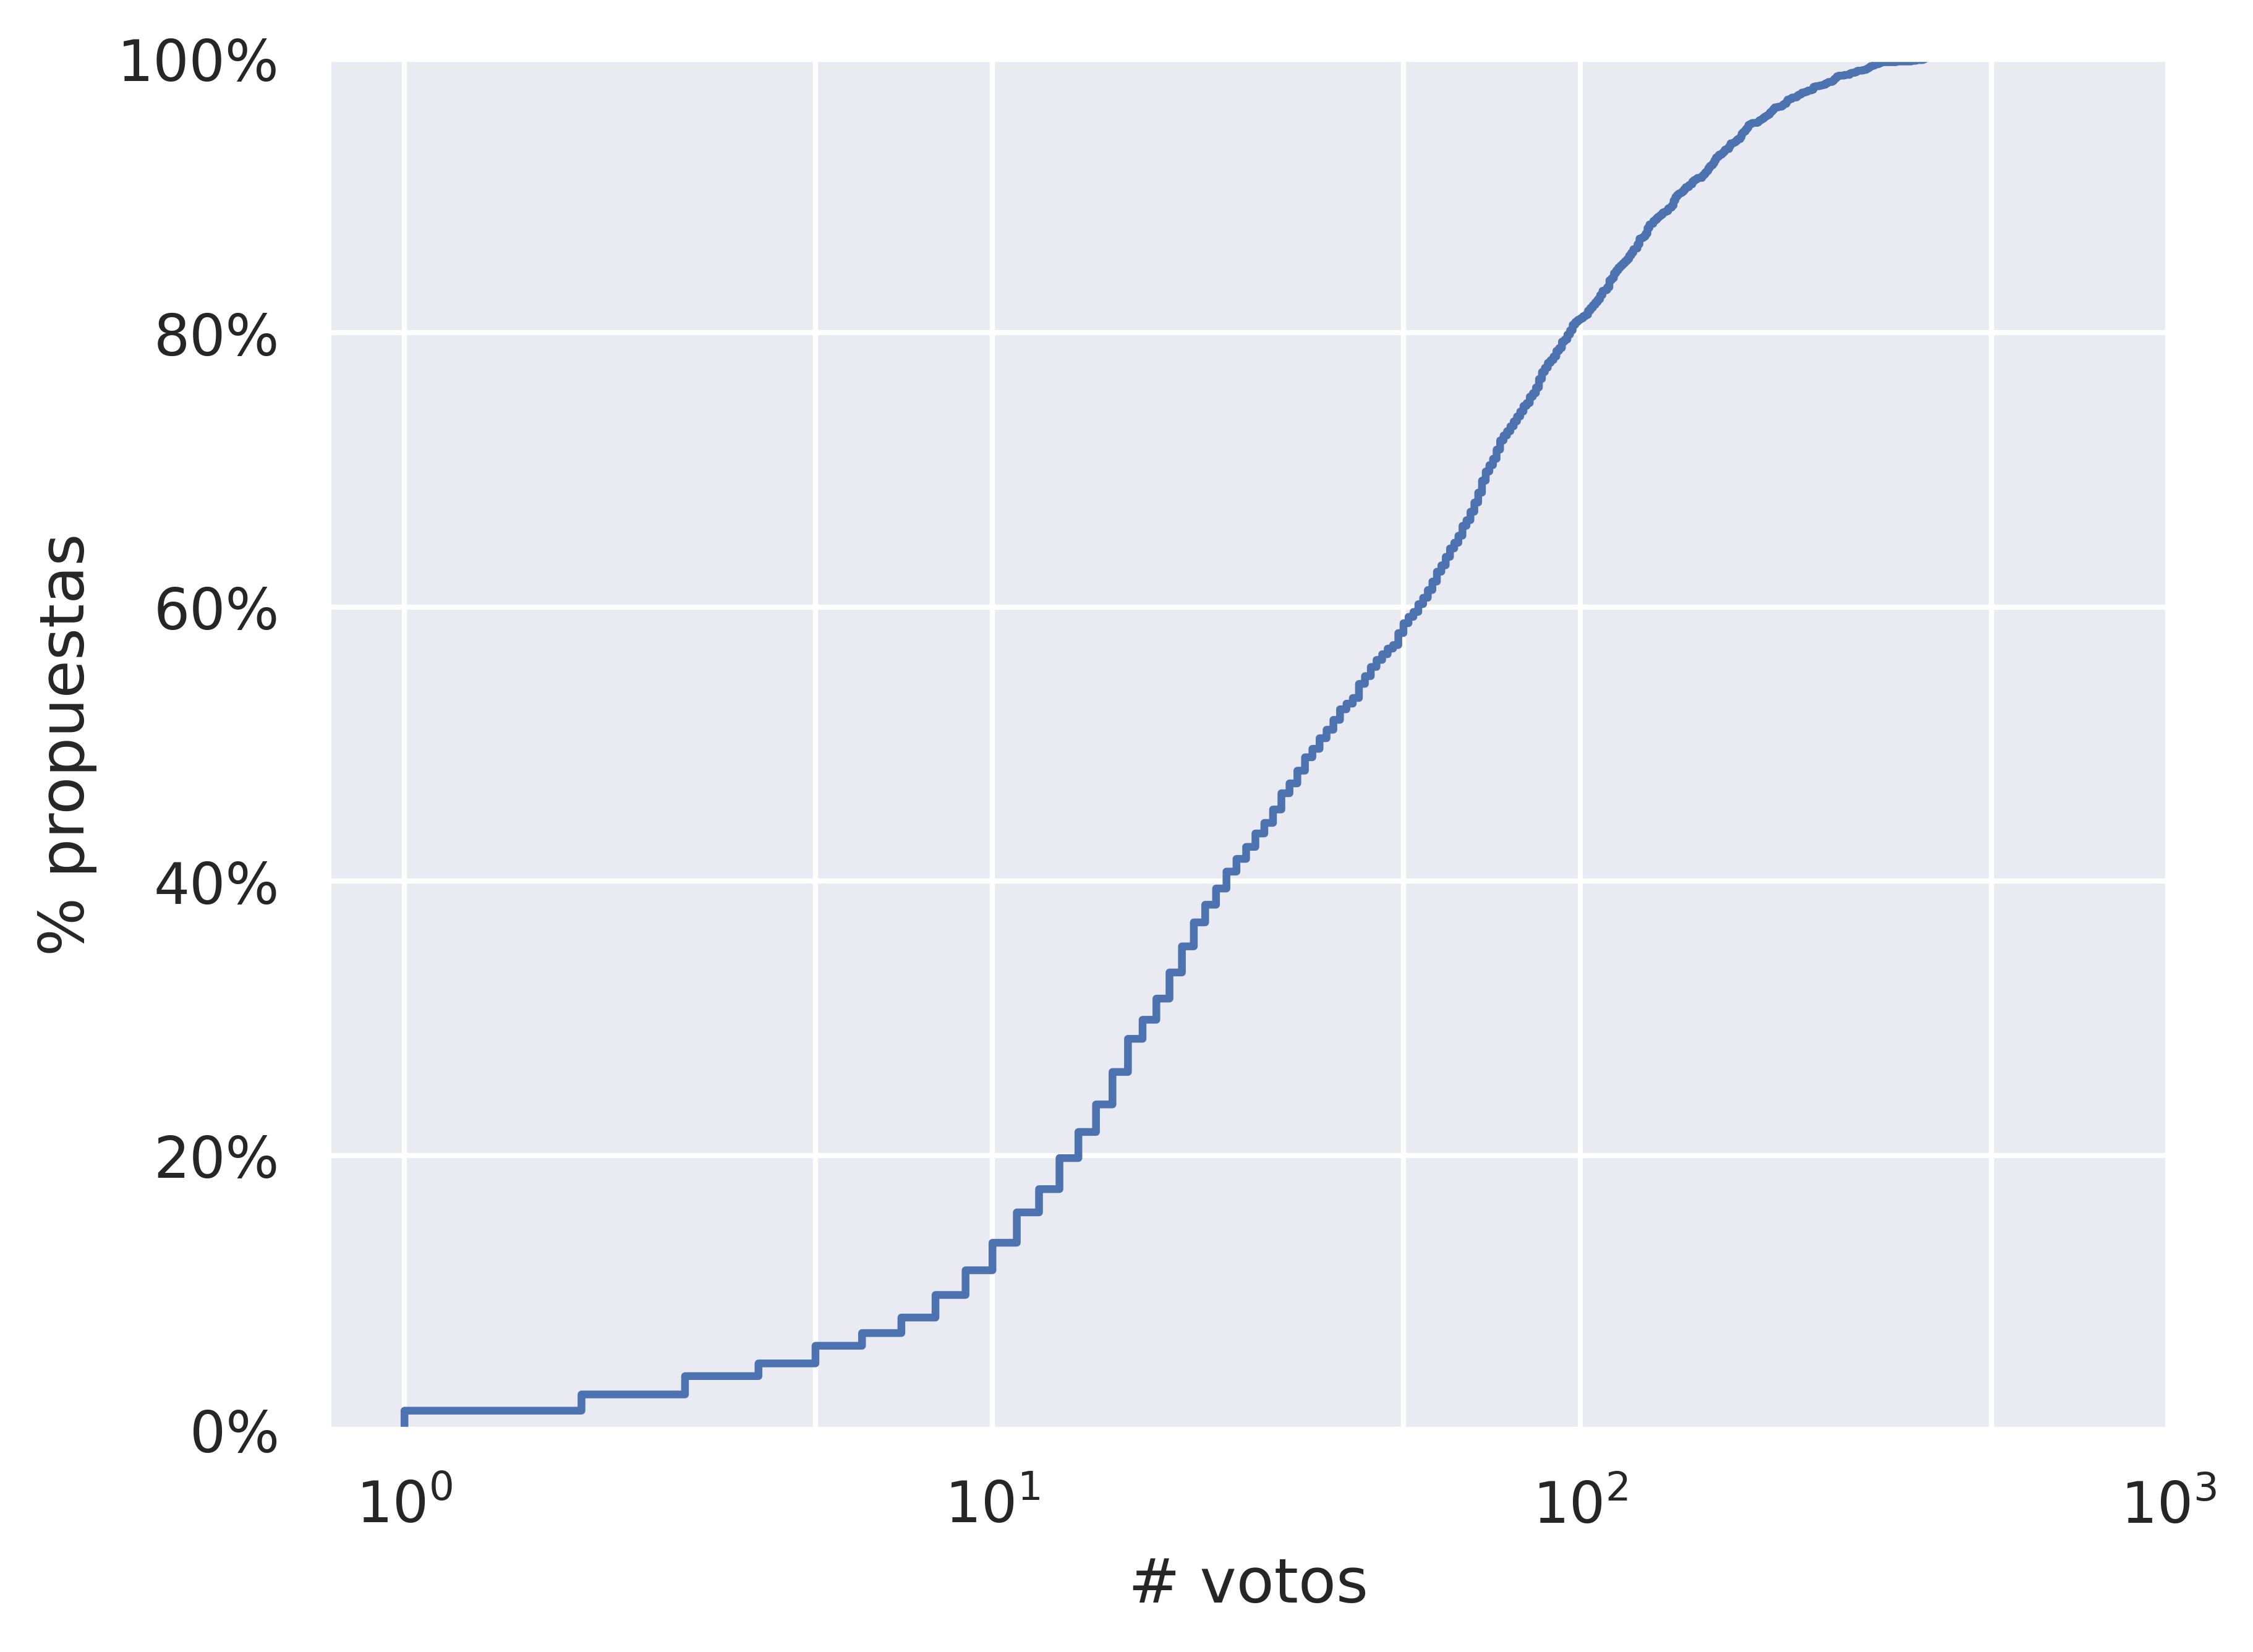

In [8]:
_toplot = dfp['votes_count']
print(_toplot.describe(percentiles=[.5,.75,.9, .95, .99]))
print( (_toplot > 300).sum() )

ax = sns.ecdfplot(_toplot, log_scale=True)
ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.xlabel('# votos')
plt.ylabel('% propuestas')

nbutils.download_matplotlib(ax.figure, f'04_hybrid_ecdf_proposals_{ORG_NAME}.pdf')

count    1942.000000
mean       60.020597
std        63.080051
min         1.000000
50%        36.000000
75%        82.000000
90%       146.000000
95%       192.950000
99%       291.360000
max       385.000000
dtype: float64
17


<Axes: ylabel='Proportion'>

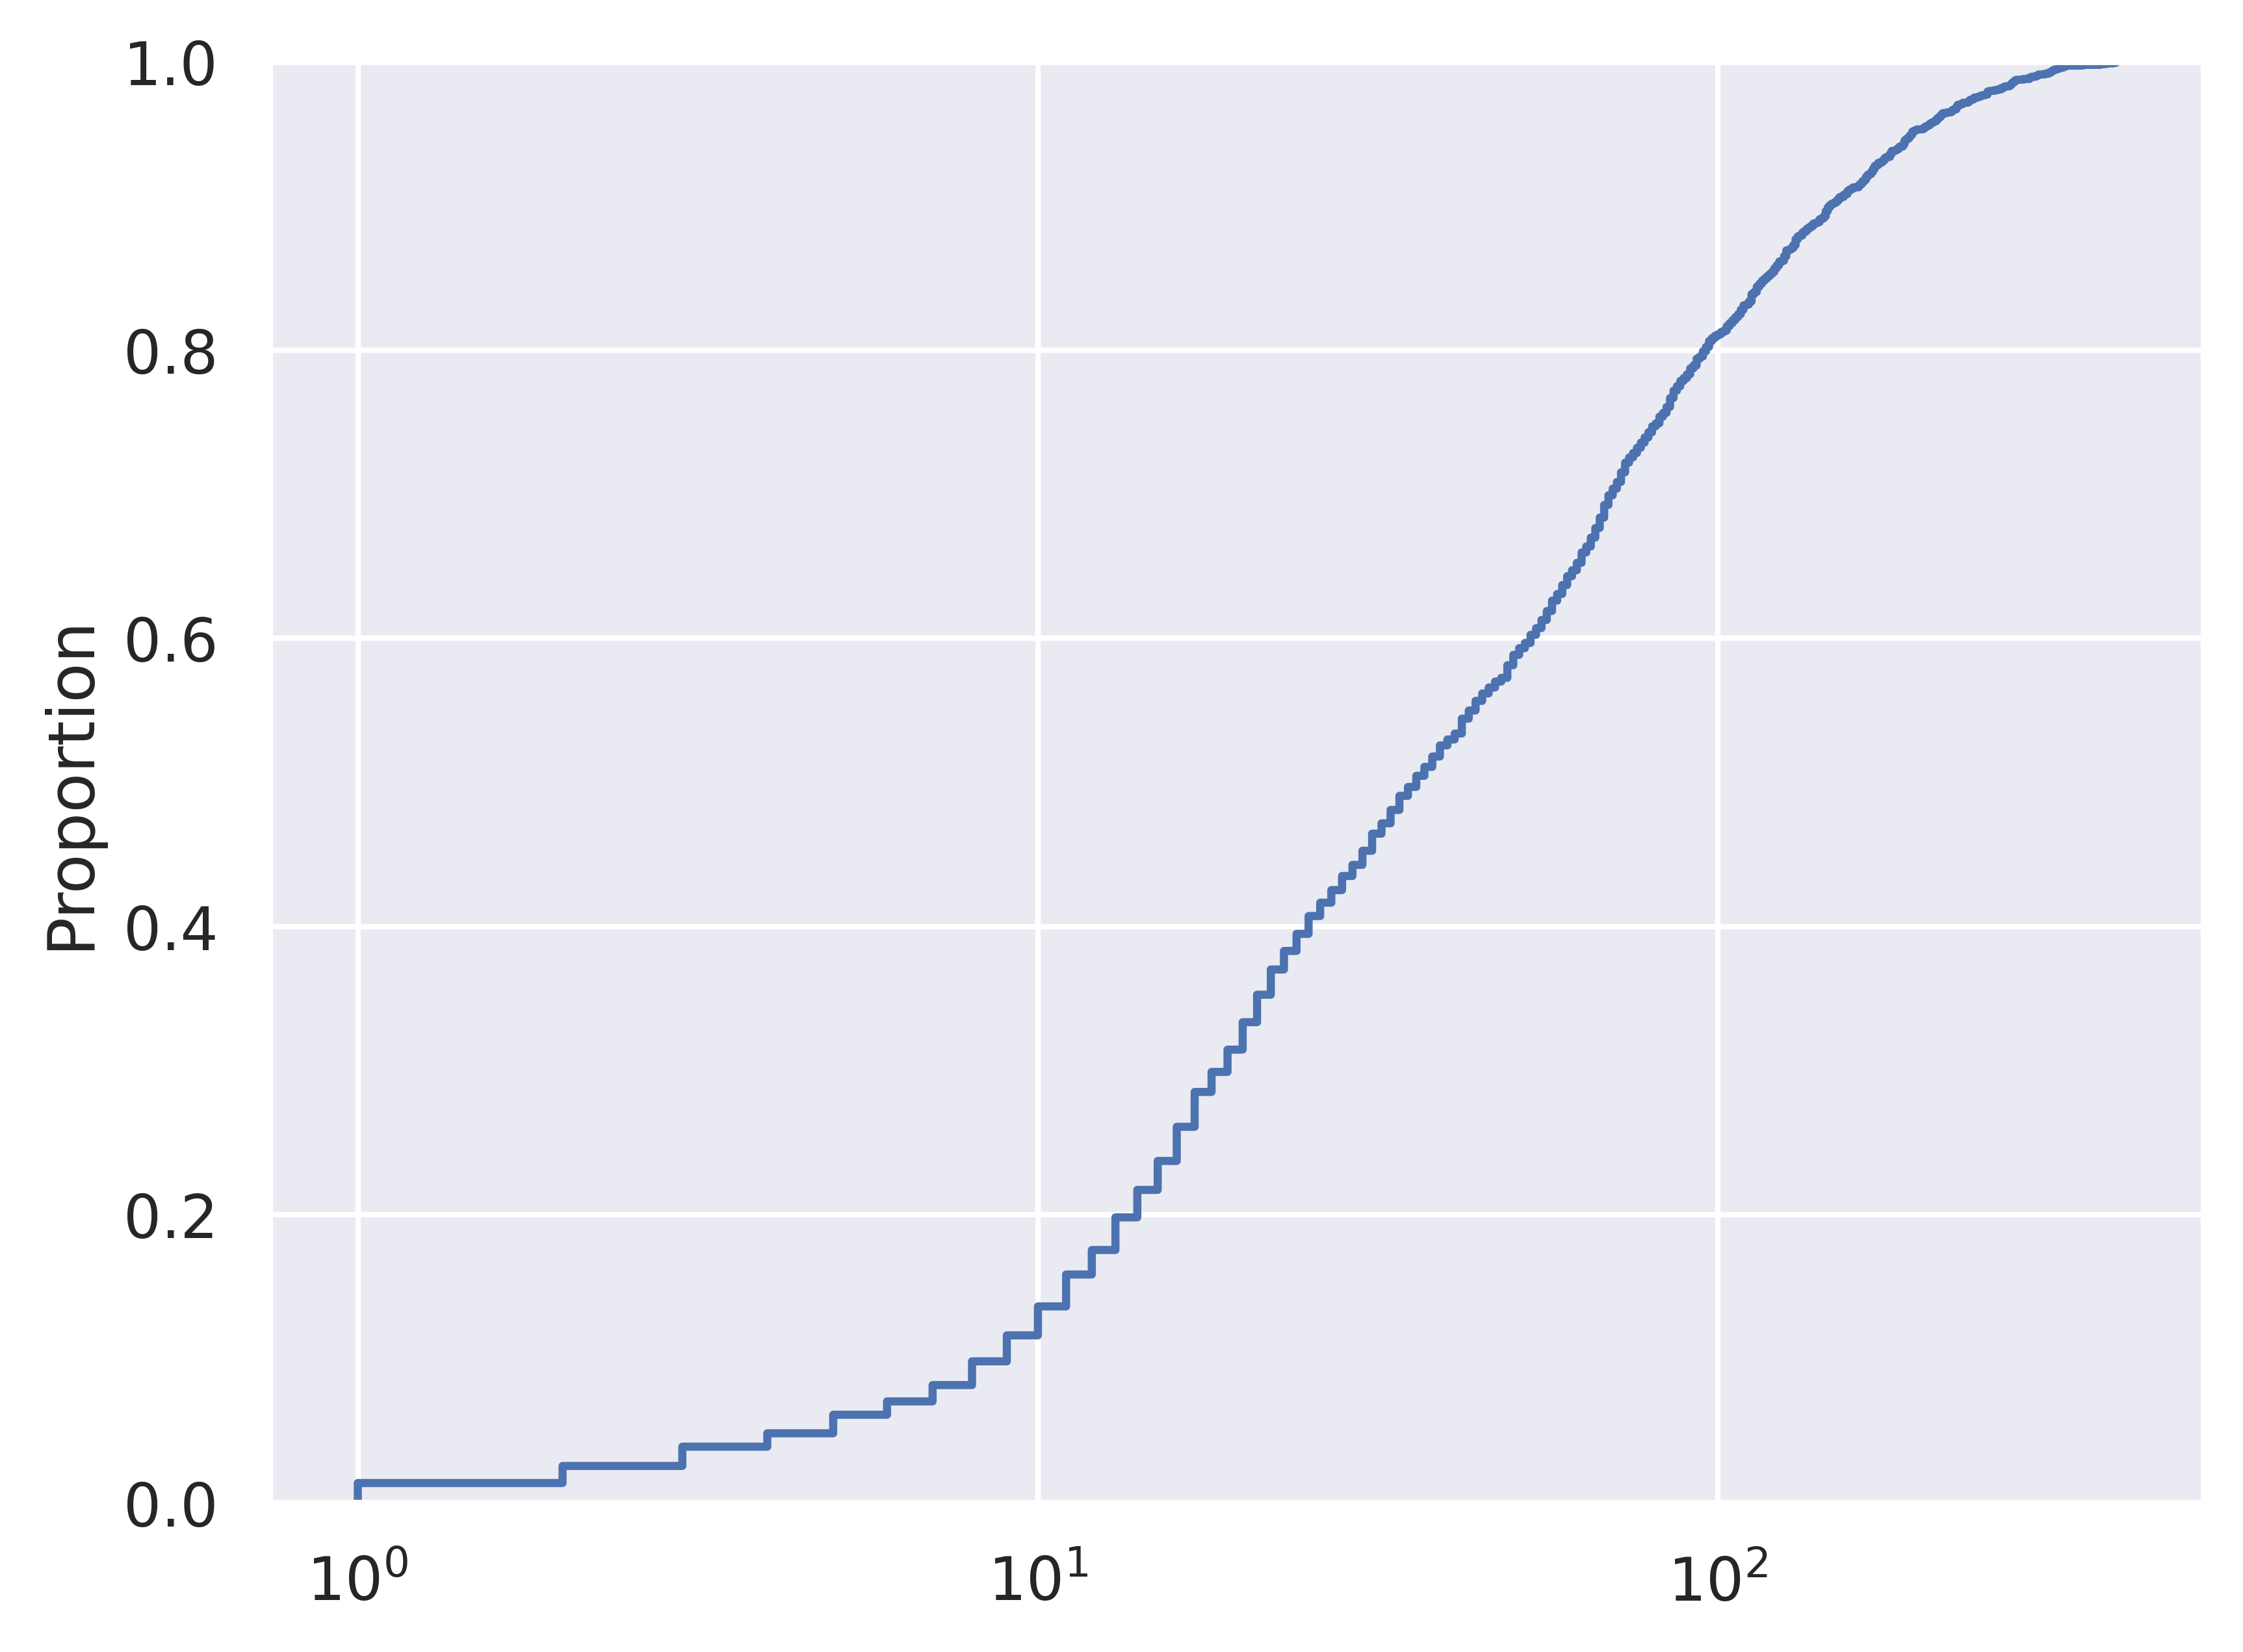

In [9]:
_toplot = dfv.groupby('proposal').size()
print(_toplot.describe(percentiles=[.5,.75,.9, .95, .99]))
print( (_toplot > 300).sum() )
sns.ecdfplot(_toplot, log_scale=True)

### Usuarios activos

In [10]:
# dfv.set_index('date').sort_index()['voter'].tolist()
# for x in dfv.set_index('date').sort_index()['voter'].items():
#     print(x)

/tmp/ipykernel_180422/3928196604.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/116560 [00:00<?, ?it/s]

2021-05-24 15:29:29 2023-07-20 15:42:01


Cannot show ipywidgets in text

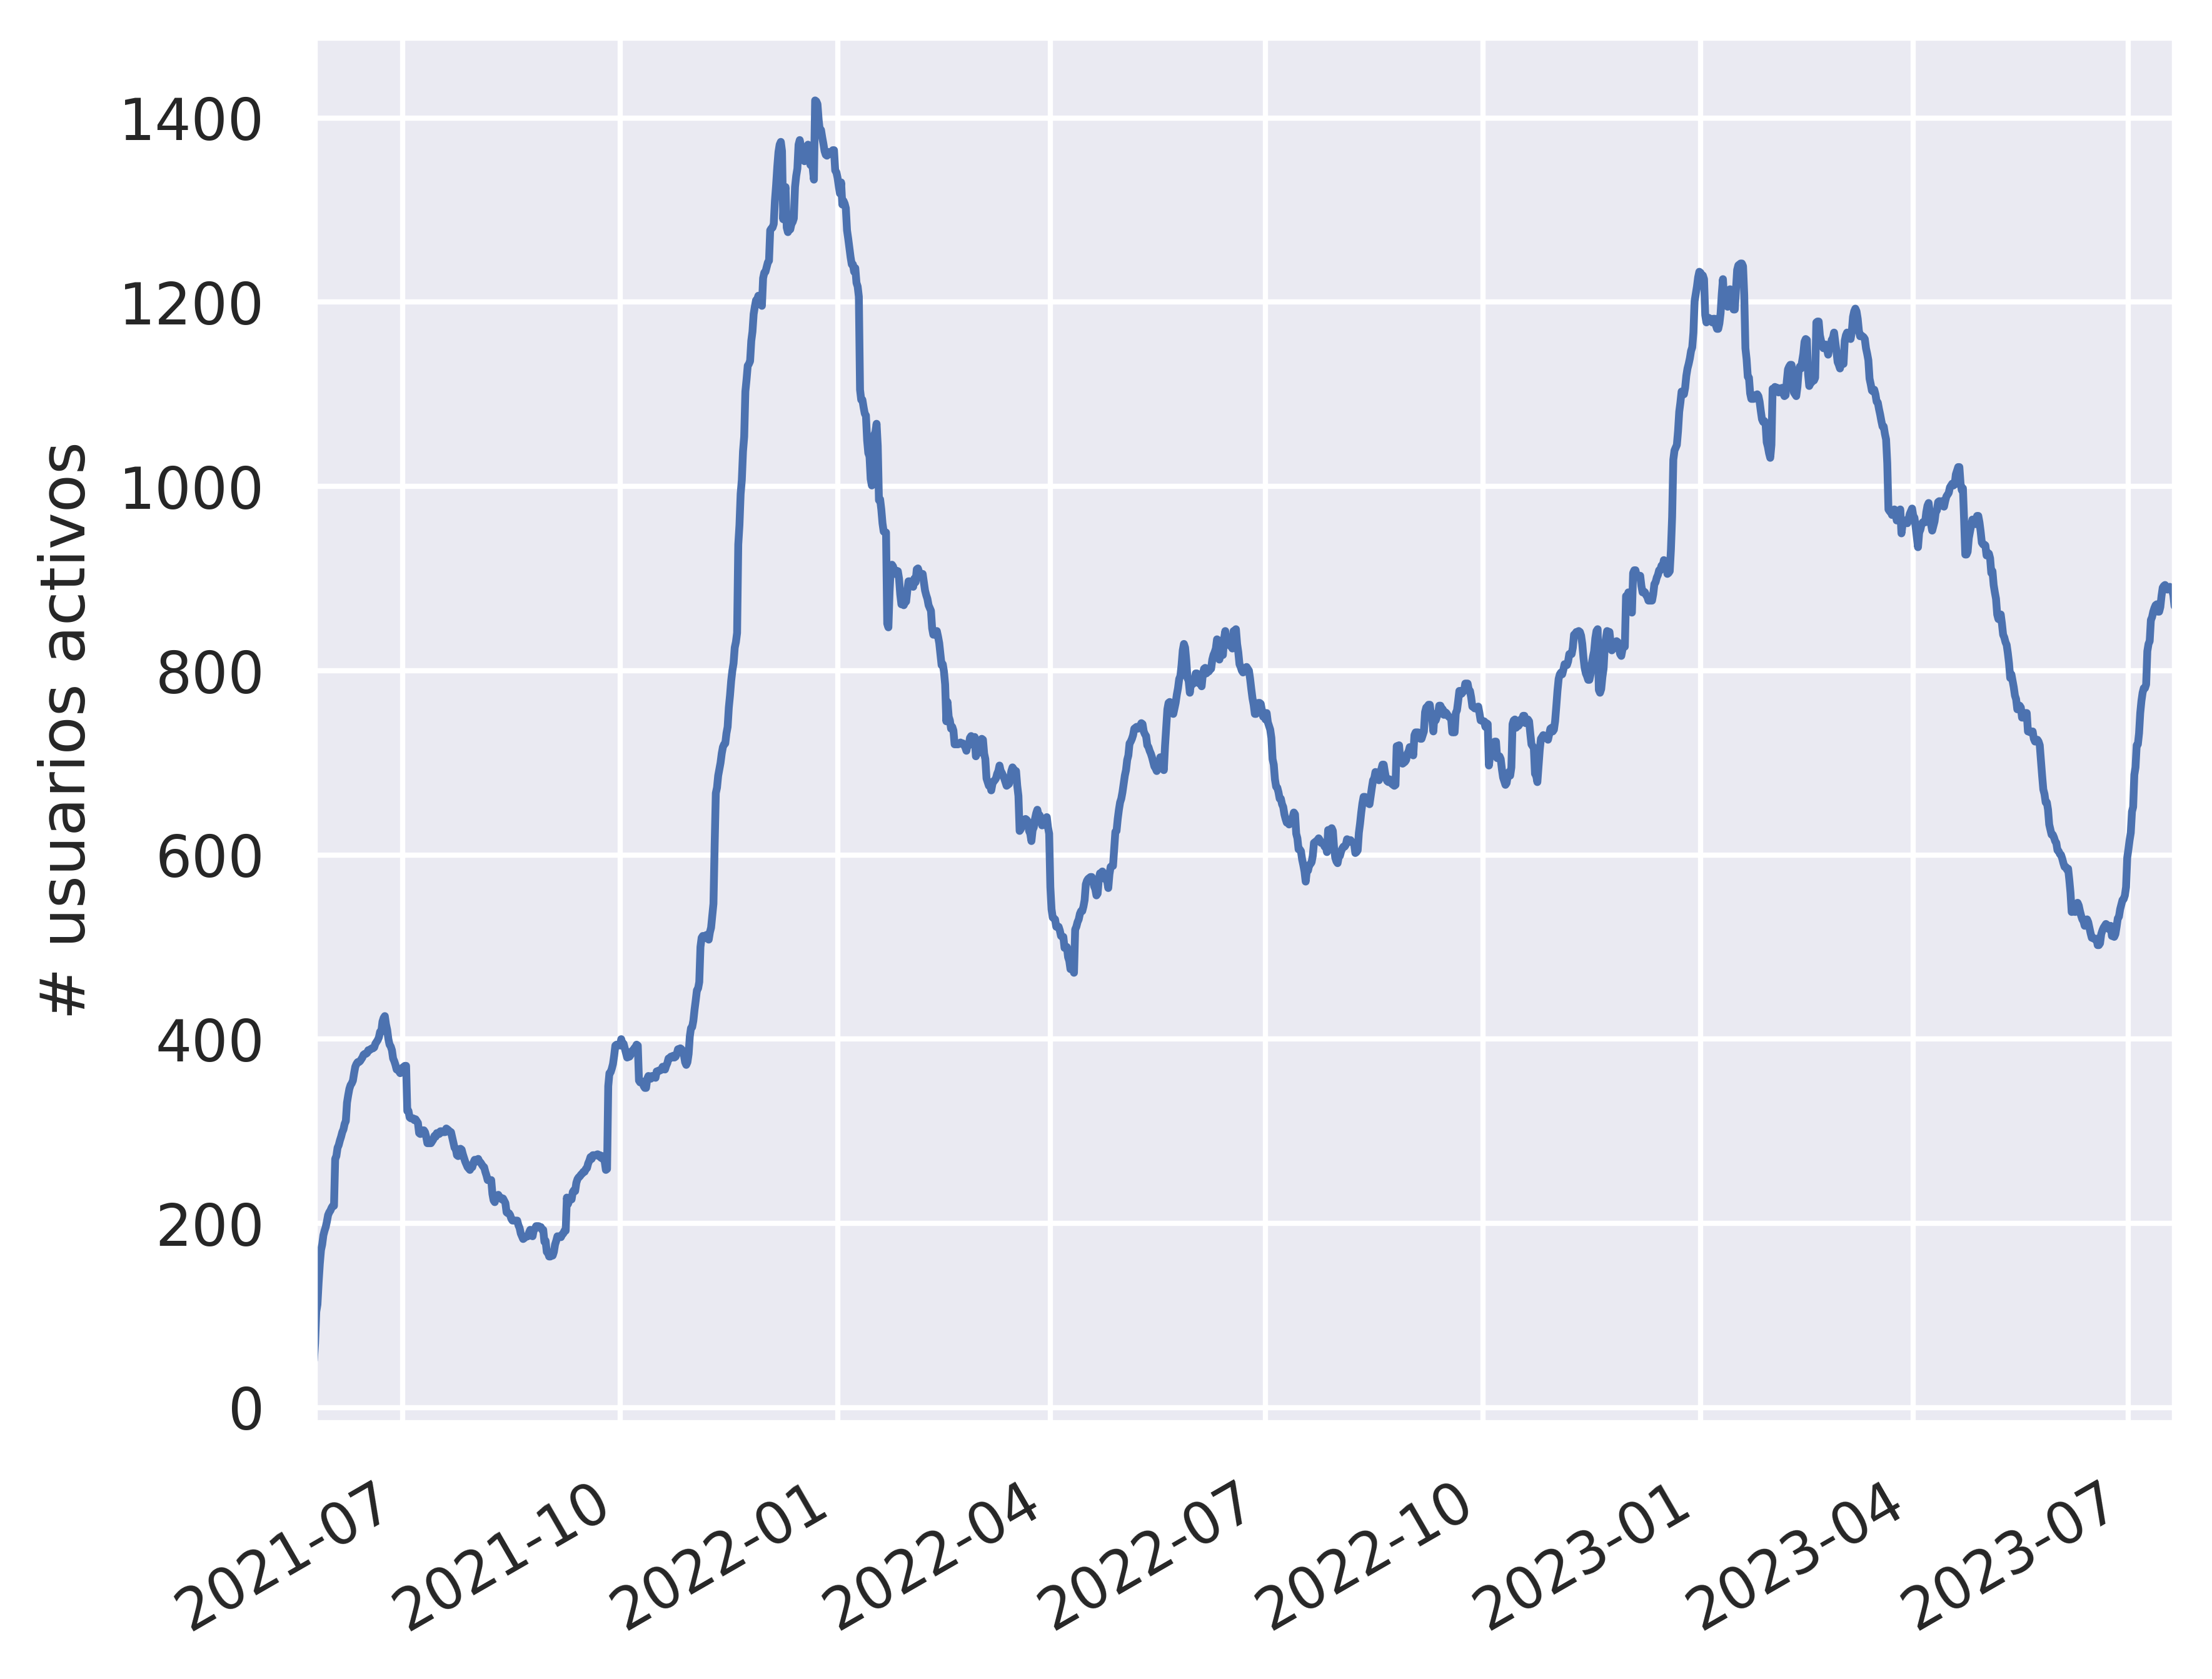

In [11]:
# import numba
from tqdm.autonotebook import tqdm
import rolling
import datetime as dt

tqdm.pandas(total=len(dfv))

# WINDOW_SIZE = '30D'
WINDOW_SIZE = dt.timedelta(days=30)

RESAMPLE_FREQ = '12h'

# @numba.jit(nopython=True)
# def nunique(arr):
#     return len(set(arr))

# Rolling no acepta tipos no númericos en la agregación, por lo que es necesario convertir la categoría a entero
# Por ejemplo, usando el código que le asigna Pandas
# dfv['ucode'] = dfv['voter'].cat.codes
#_cnt = dfv.set_index('date').sort_index().rolling(WINDOW_SIZE)['ucode'].progress_apply(nunique, raw=True).rename('cnt')

# Al final resulta que lo mejor era ir a por la solución O(1)
_voters = dfv.set_index('date').sort_index()['voter'] # .cat.codes
r = tqdm(
    rolling.arithmetic.Nunique(_voters.items(), WINDOW_SIZE, window_type='indexed'),
    total=len(dfv),
)
_cnt = pd.Series(r, index=_voters.index)
# Need to resample or there would be too many points
_cnt = _cnt.resample(RESAMPLE_FREQ).max()

print(dfv['date'].min(), dfv['date'].max())
ax = sns.lineplot(_cnt)
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# usuarios activos')
plt.xlim(dfv['date'].min(), dfv['date'].max())
nbutils.download_matplotlib(ax.figure, f'04c_rolling_voters_{WINDOW_SIZE}_{ORG_NAME}.png')

## Cuando se unen los usuarios

Es decir, cuando votan por primera vez

Cannot show ipywidgets in text

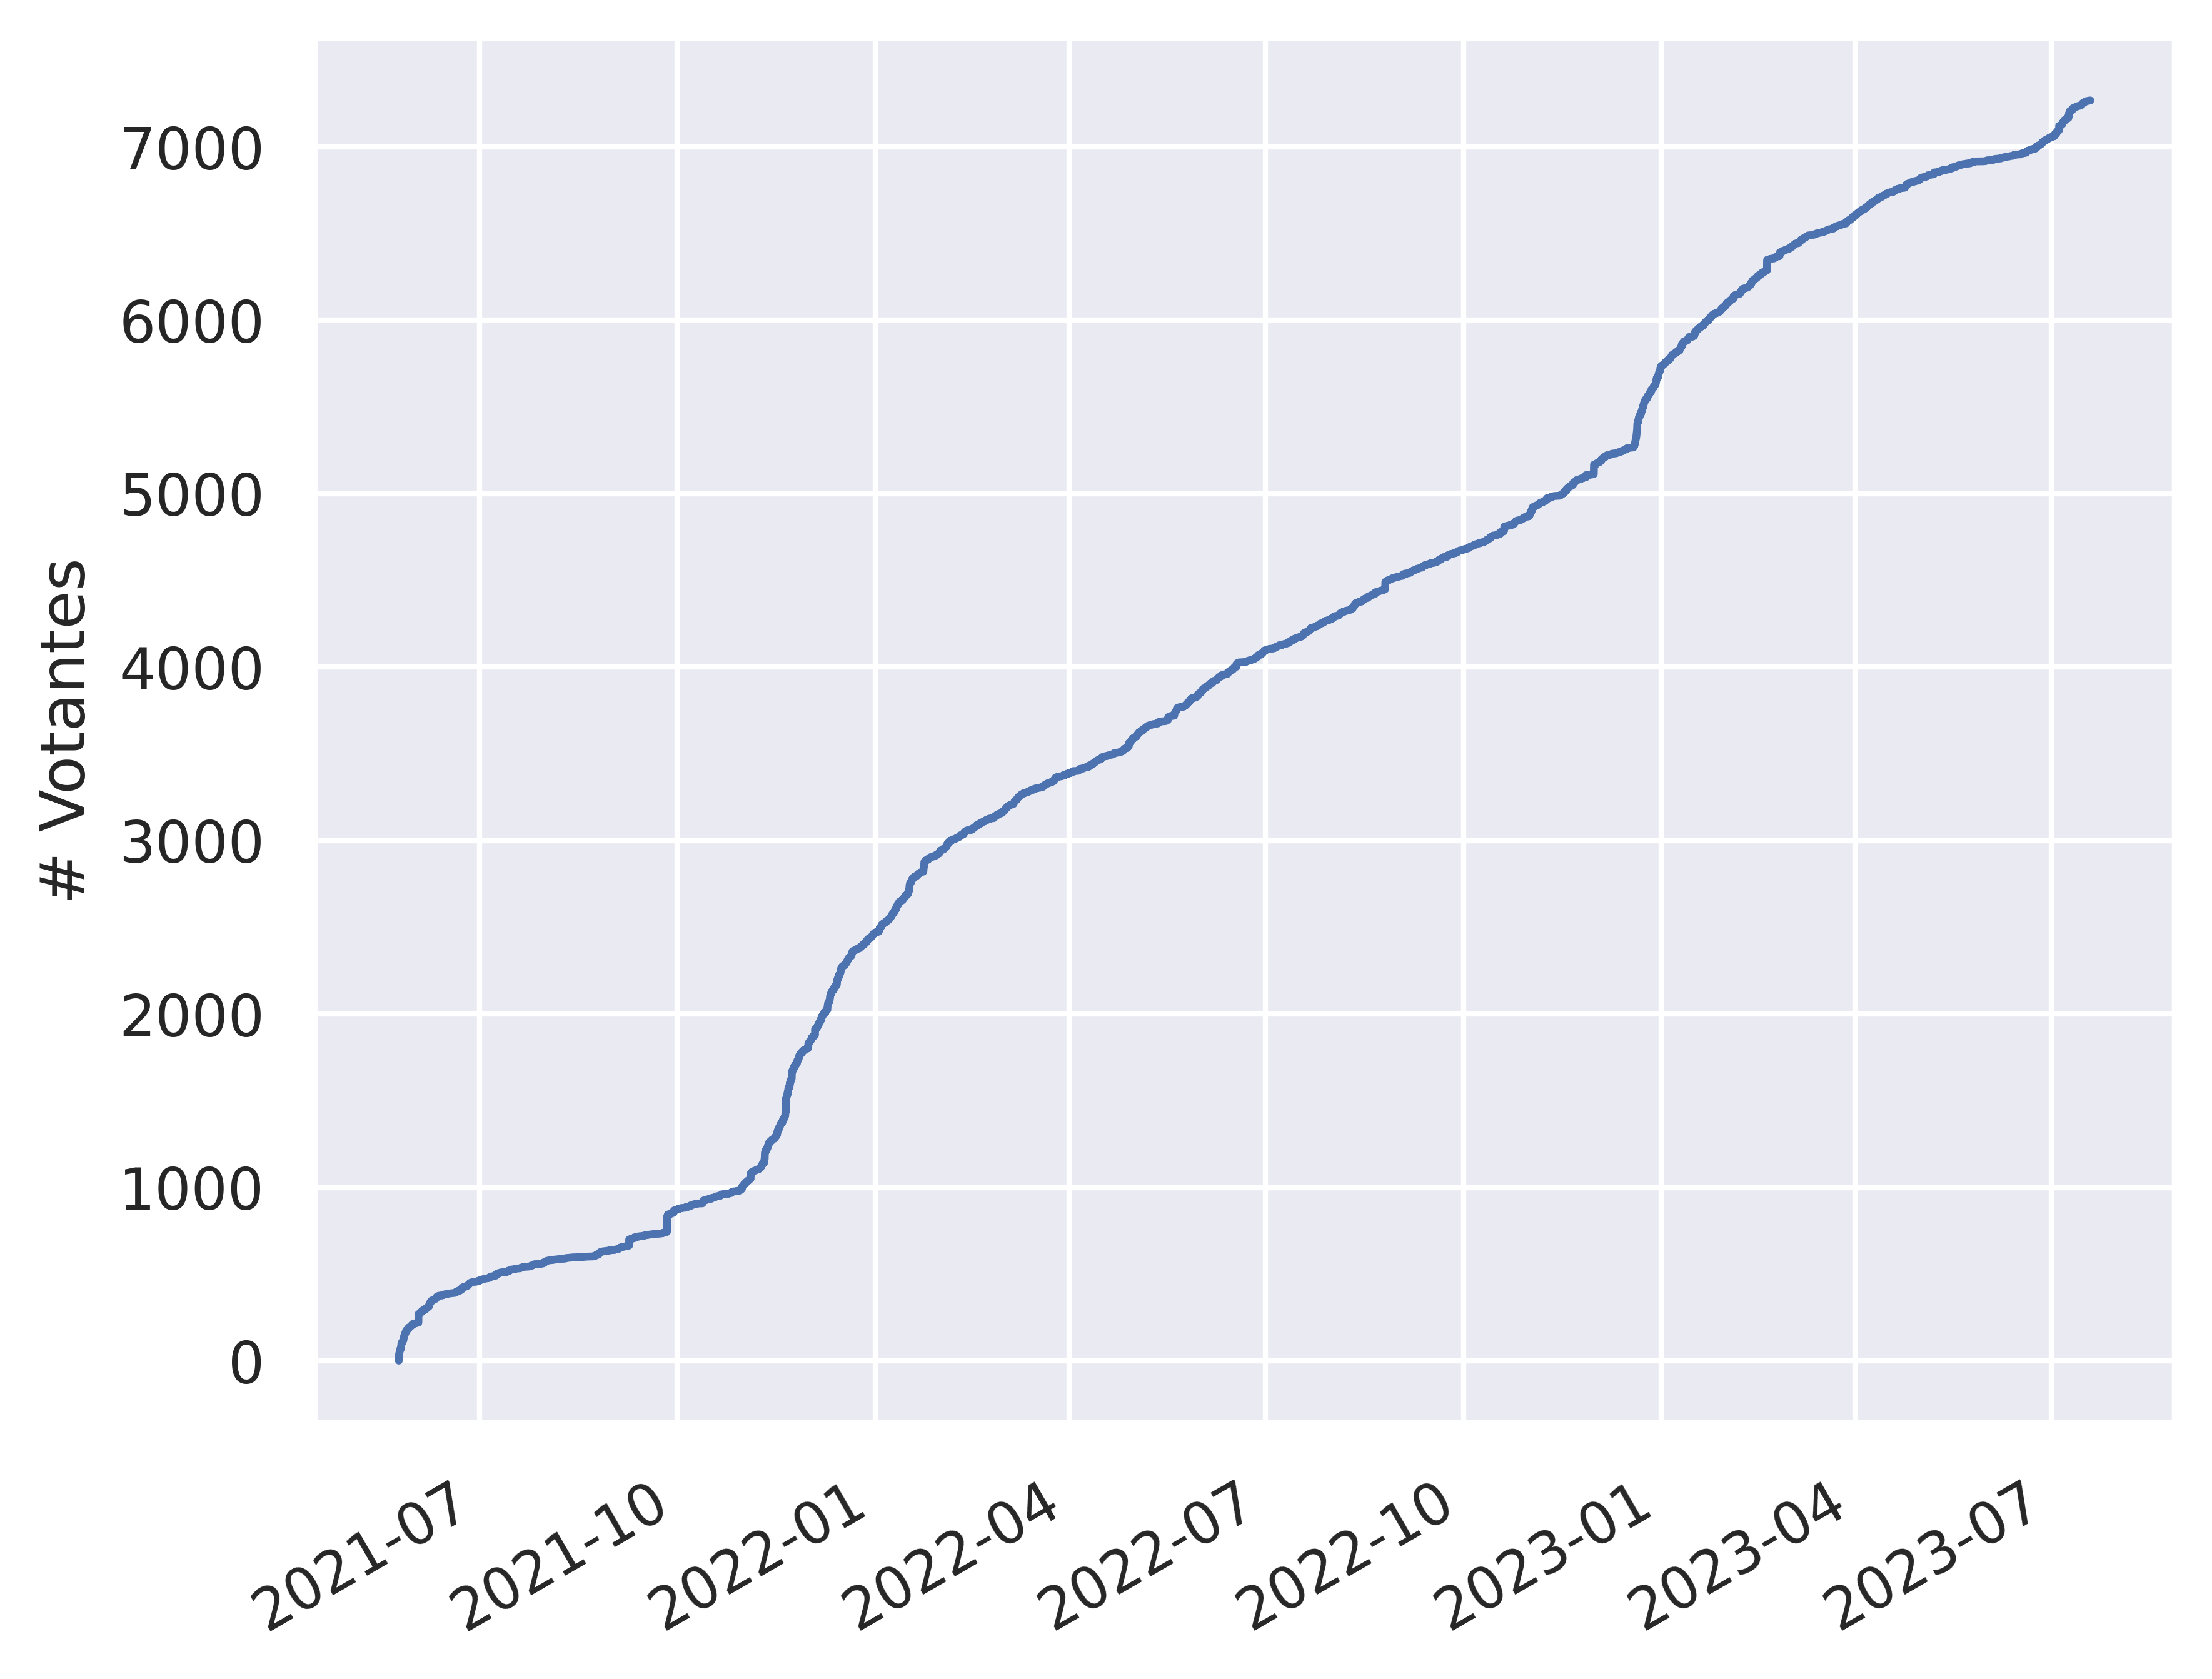

In [12]:
_toplot = dfv.groupby('voter')['date'].min()
_toplot = _toplot.sort_values().to_frame()
_toplot['cnt'] = 1
_toplot['cumcnt'] = _toplot['cnt'].cumsum()
ax = sns.lineplot(_toplot, x='date', y='cumcnt')
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# Votantes')

nbutils.download_matplotlib(ax.figure, f'04_hybrid_cumcnt_users_{ORG_NAME}.pdf')

## Cuando se crean las propuestas

Cannot show ipywidgets in text

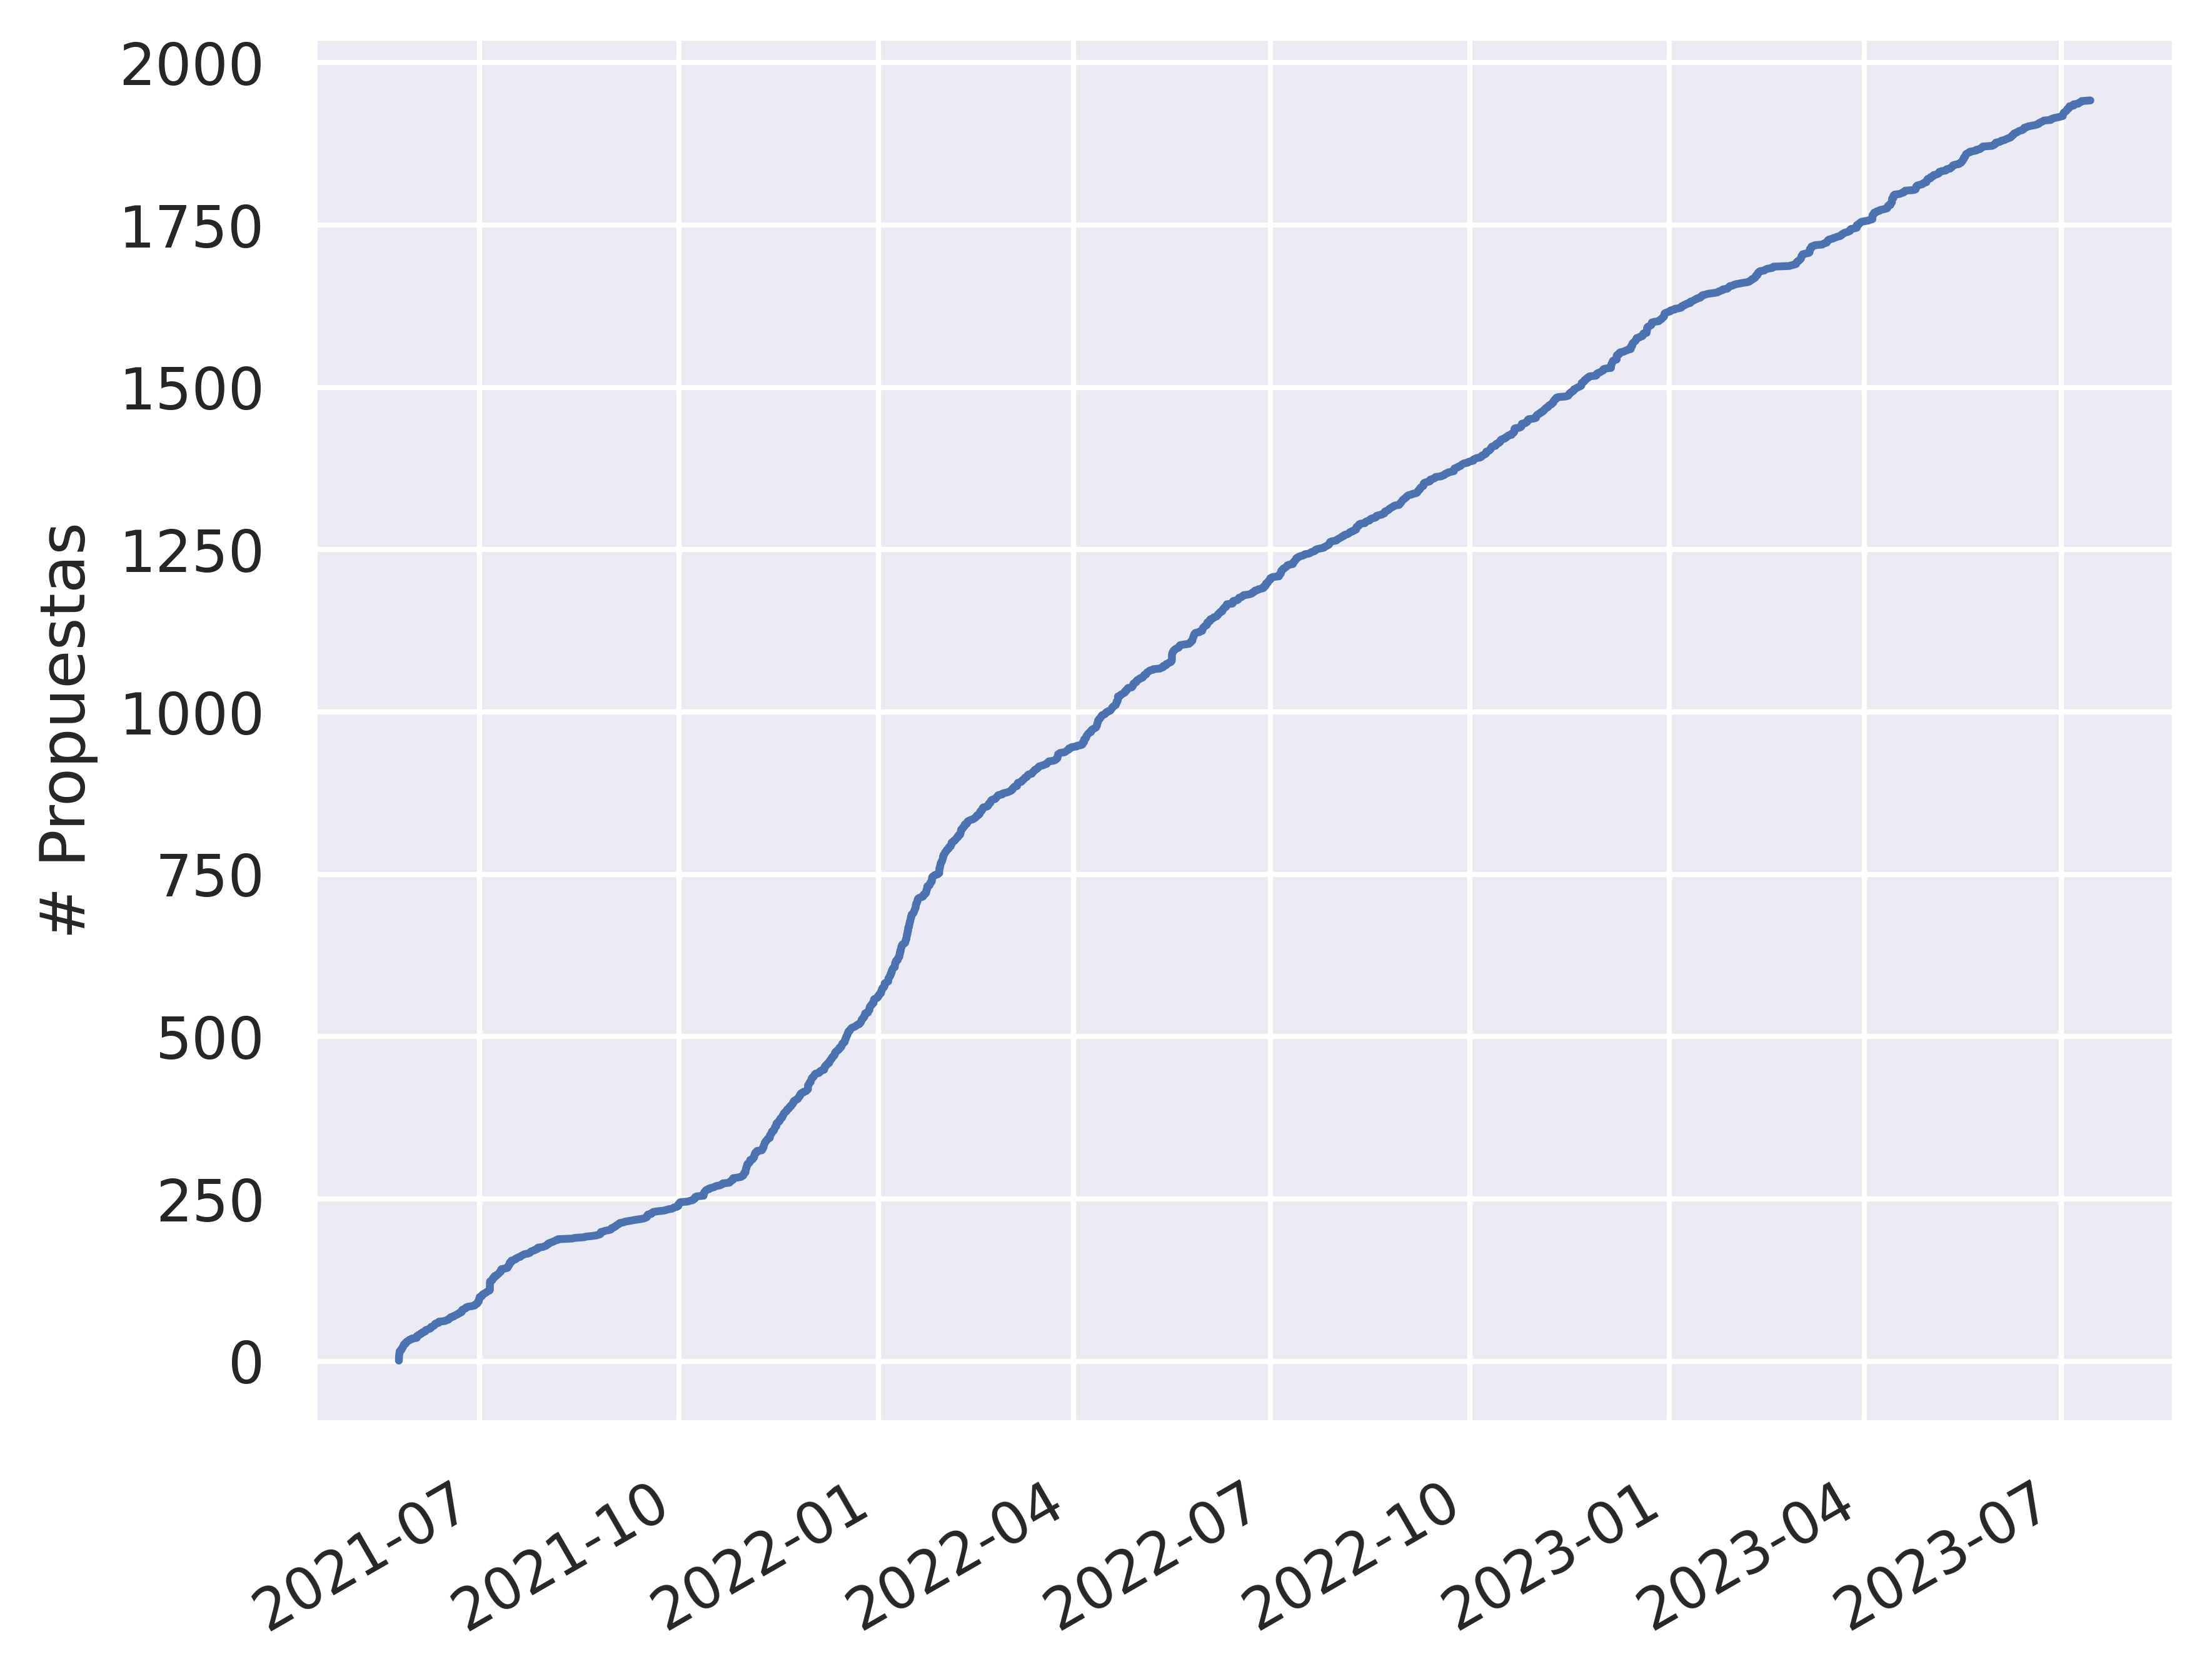

In [13]:
_toplot = dfv.groupby('proposal')['date'].min()
_toplot = _toplot.sort_values().to_frame()
_toplot['cnt'] = 1
_toplot['cumcnt'] = _toplot['cnt'].cumsum()
ax = sns.lineplot(_toplot, x='date', y='cumcnt')
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# Propuestas')

nbutils.download_matplotlib(ax.figure, f'04c_cumcnt_users_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

<Figure size 3840x2880 with 0 Axes>

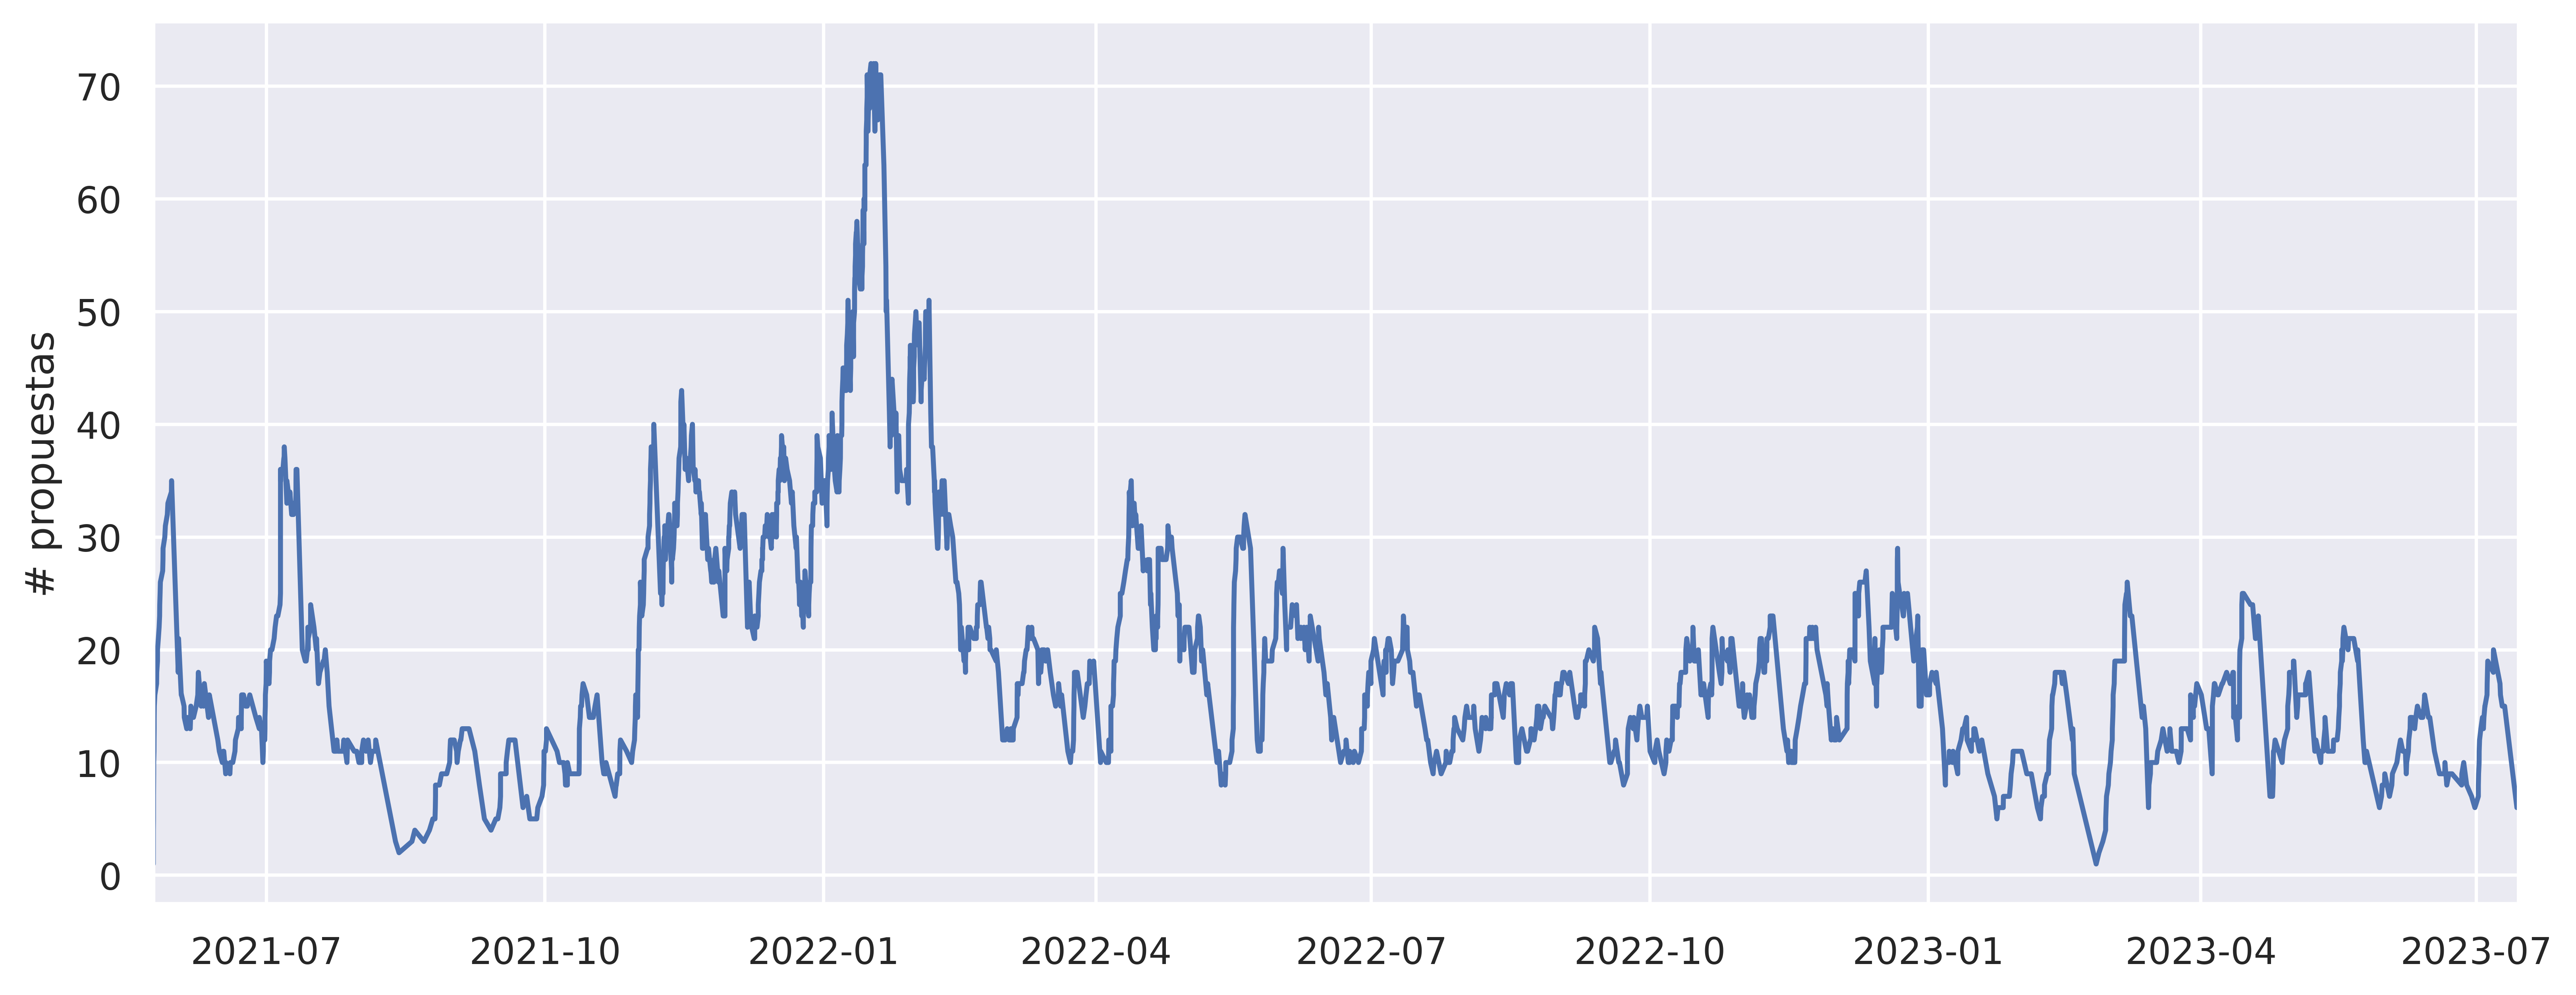

In [14]:
WINDOW_SIZE = '7D'

_toplot = dfv.groupby('proposal')['date'].min().sort_values()
_toplot = _toplot.to_frame()
_toplot['cnt'] = 1
_toplot = _toplot.rolling(window=WINDOW_SIZE, on='date').count()

# Double the width of the figure
fs = plt.gcf().get_size_inches()
plt.figure(figsize=(fs[0]*2, fs[1]))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)

sns.despine()
nbutils.download_matplotlib(ax.figure, f'04c_rolling_proposals_{WINDOW_SIZE}_{ORG_NAME}.pdf')

## Dia de la semana en que se votan las propuestas

> incluso, se podría hacer un heatmap X cuando se lanzan Y cuando se votan y Z (color) la frecuencia
> -- Javi

Vamos, que en esta celda vamos a intentar hacer un HEATMAP donde:
- X: dia de la semana de creación de la propuesta
- Y: dia de la semana de votación
- Z: número de votos

In [15]:
_toplot.to_numpy()

array([[Timestamp('2021-05-24 15:29:29'), 1.0],
       [Timestamp('2021-05-24 15:30:54'), 2.0],
       [Timestamp('2021-05-24 15:38:54'), 3.0],
       ...,
       [Timestamp('2023-07-10 06:56:50'), 15.0],
       [Timestamp('2023-07-10 08:47:30'), 15.0],
       [Timestamp('2023-07-14 09:52:40'), 6.0]], dtype=object)

Text(277.49999999999994, 0.5, 'Día votación')

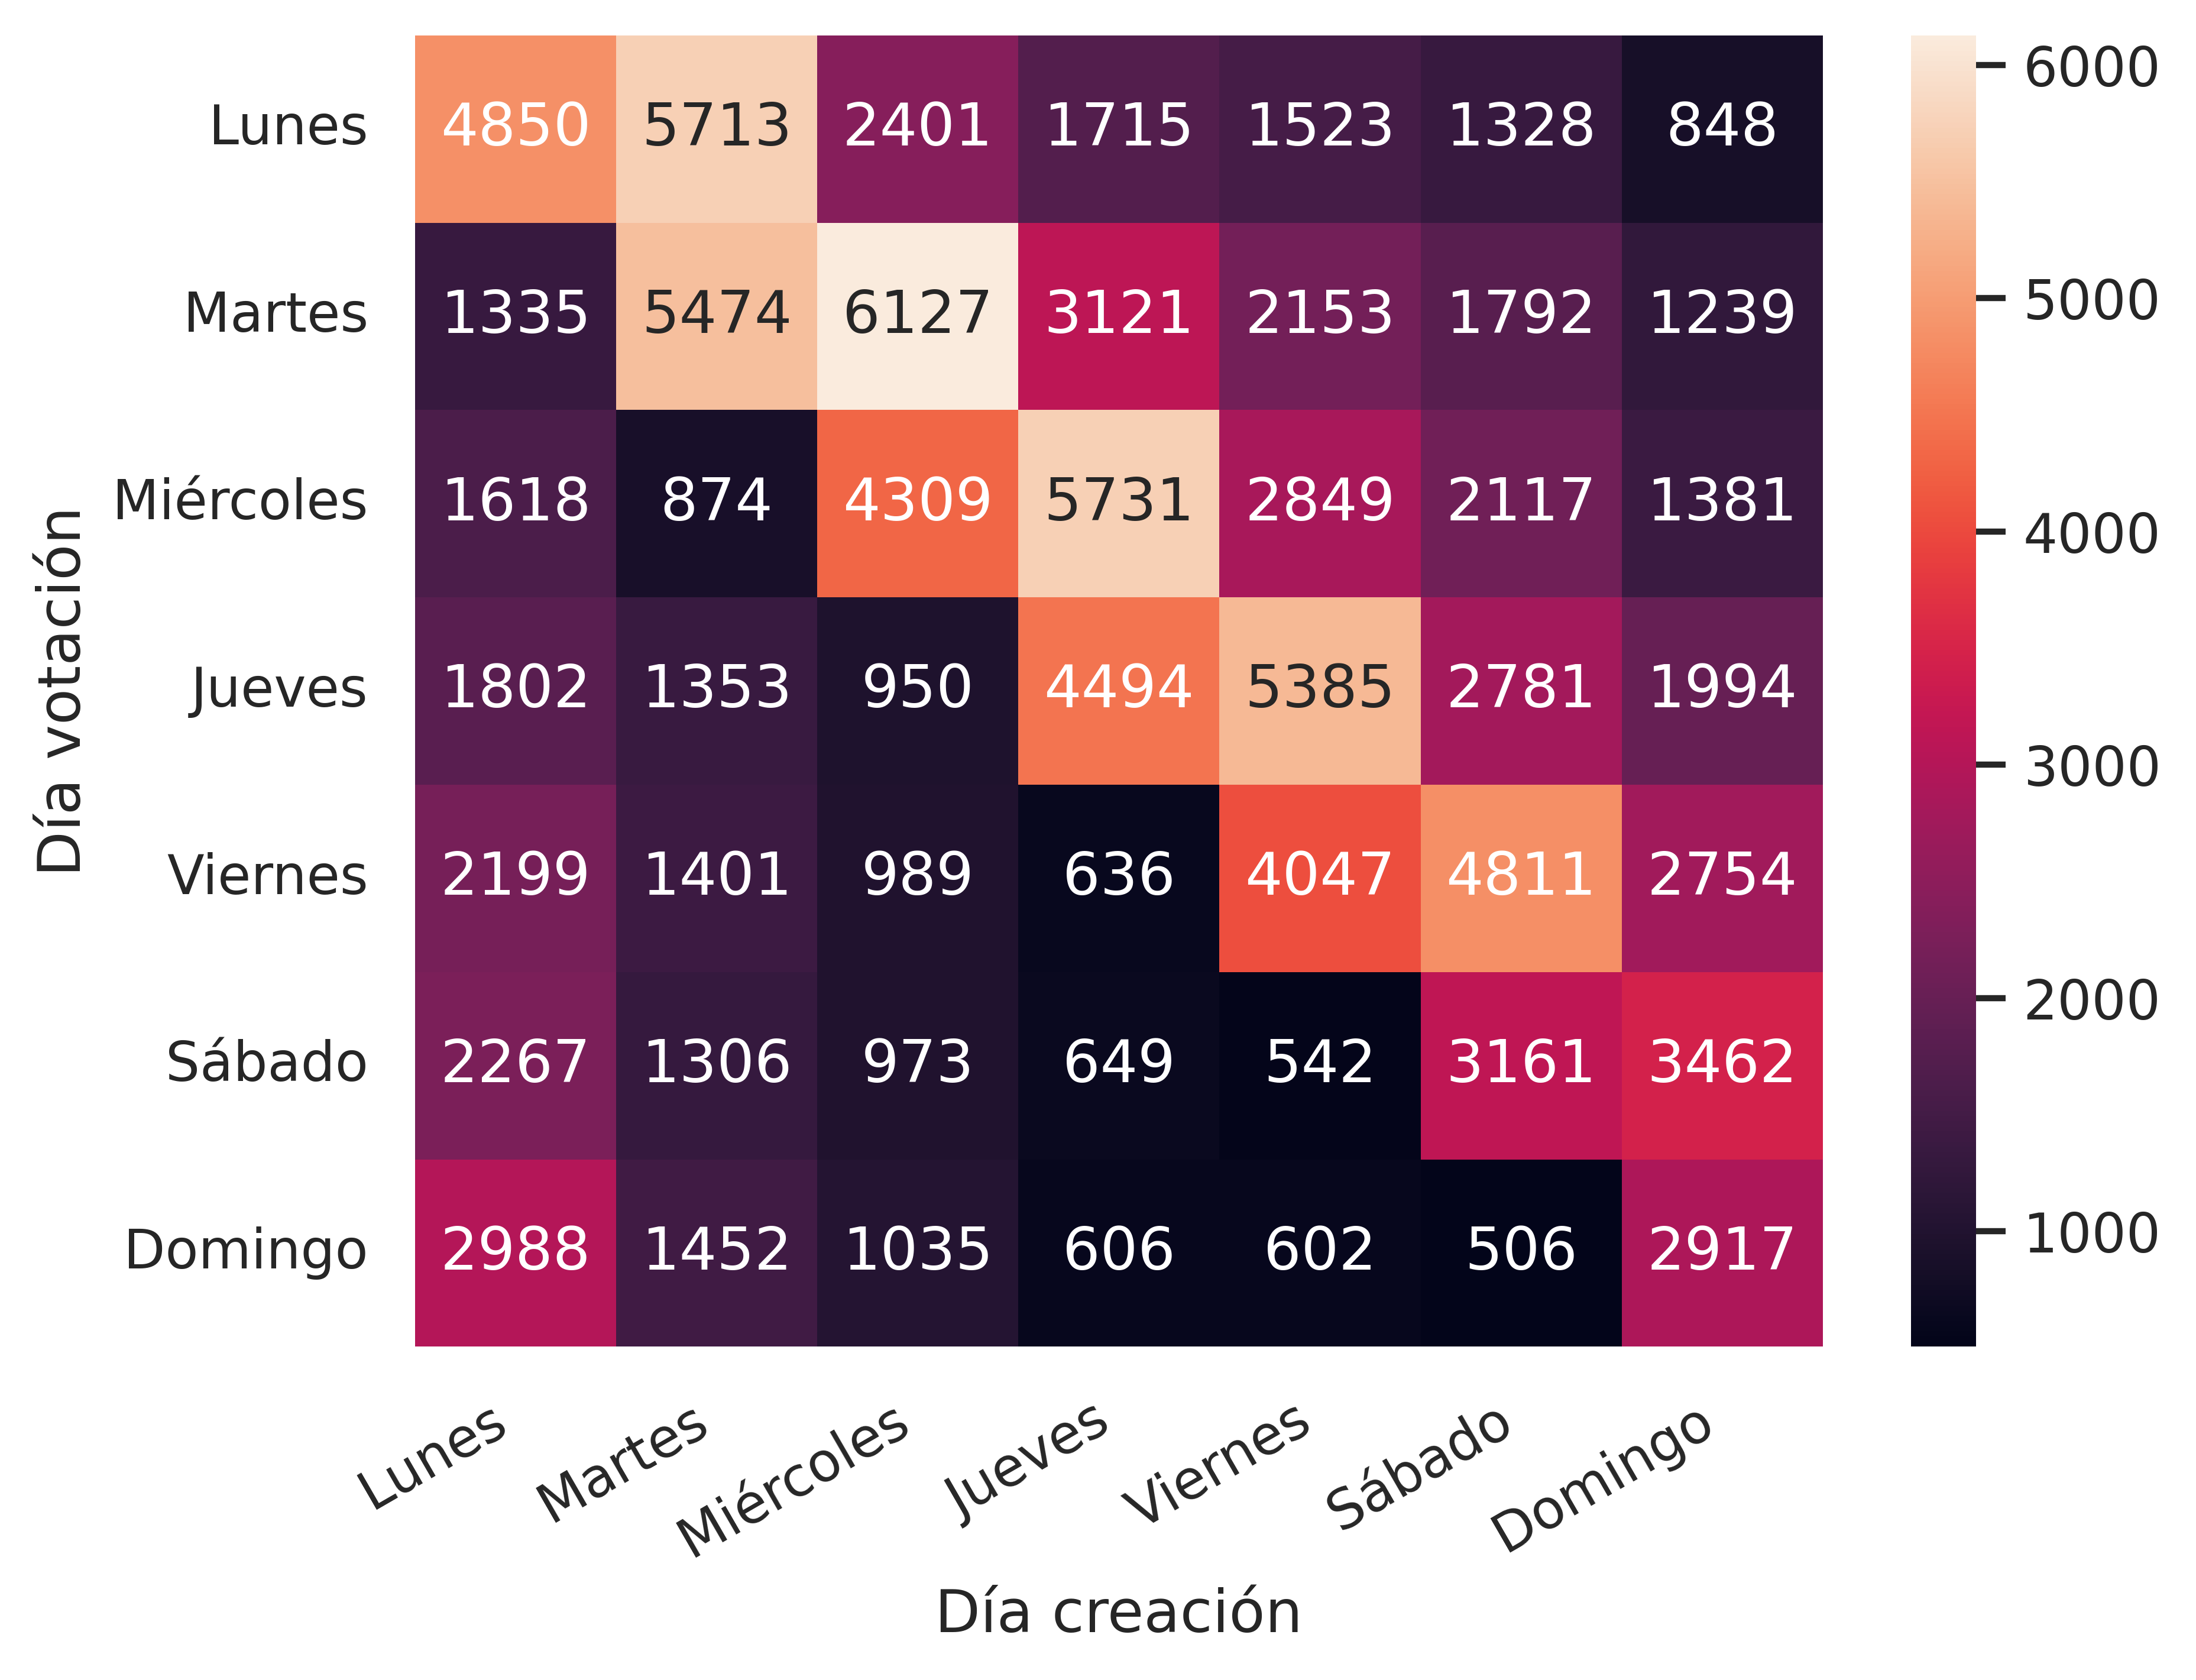

In [16]:
# In pandas, 0 = Monday
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofweek.html

spanish_dow = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes', 
    5: 'Sábado',
    6: 'Domingo',
}

_dfvp = dfv.merge(dfp['date'].rename('proposal_date'), left_on='proposal', right_index=True)
_dfvp['date_dow'] = _dfvp['date'].dt.day_of_week
_dfvp['proposal_date_dow'] = _dfvp['proposal_date'].dt.dayofweek
# sns.load_dataset("glue").pivot(index="Model", columns="Task", values="Score")
_toplot = pd.crosstab(_dfvp['proposal_date_dow'], _dfvp['date_dow']).rename(index=spanish_dow, columns=spanish_dow)

sns.heatmap(_toplot, annot=True, fmt='g')
plt.xticks(rotation=30, ha='right')

plt.xlabel('Día creación')
plt.ylabel('Día votación')

Cannot show ipywidgets in text

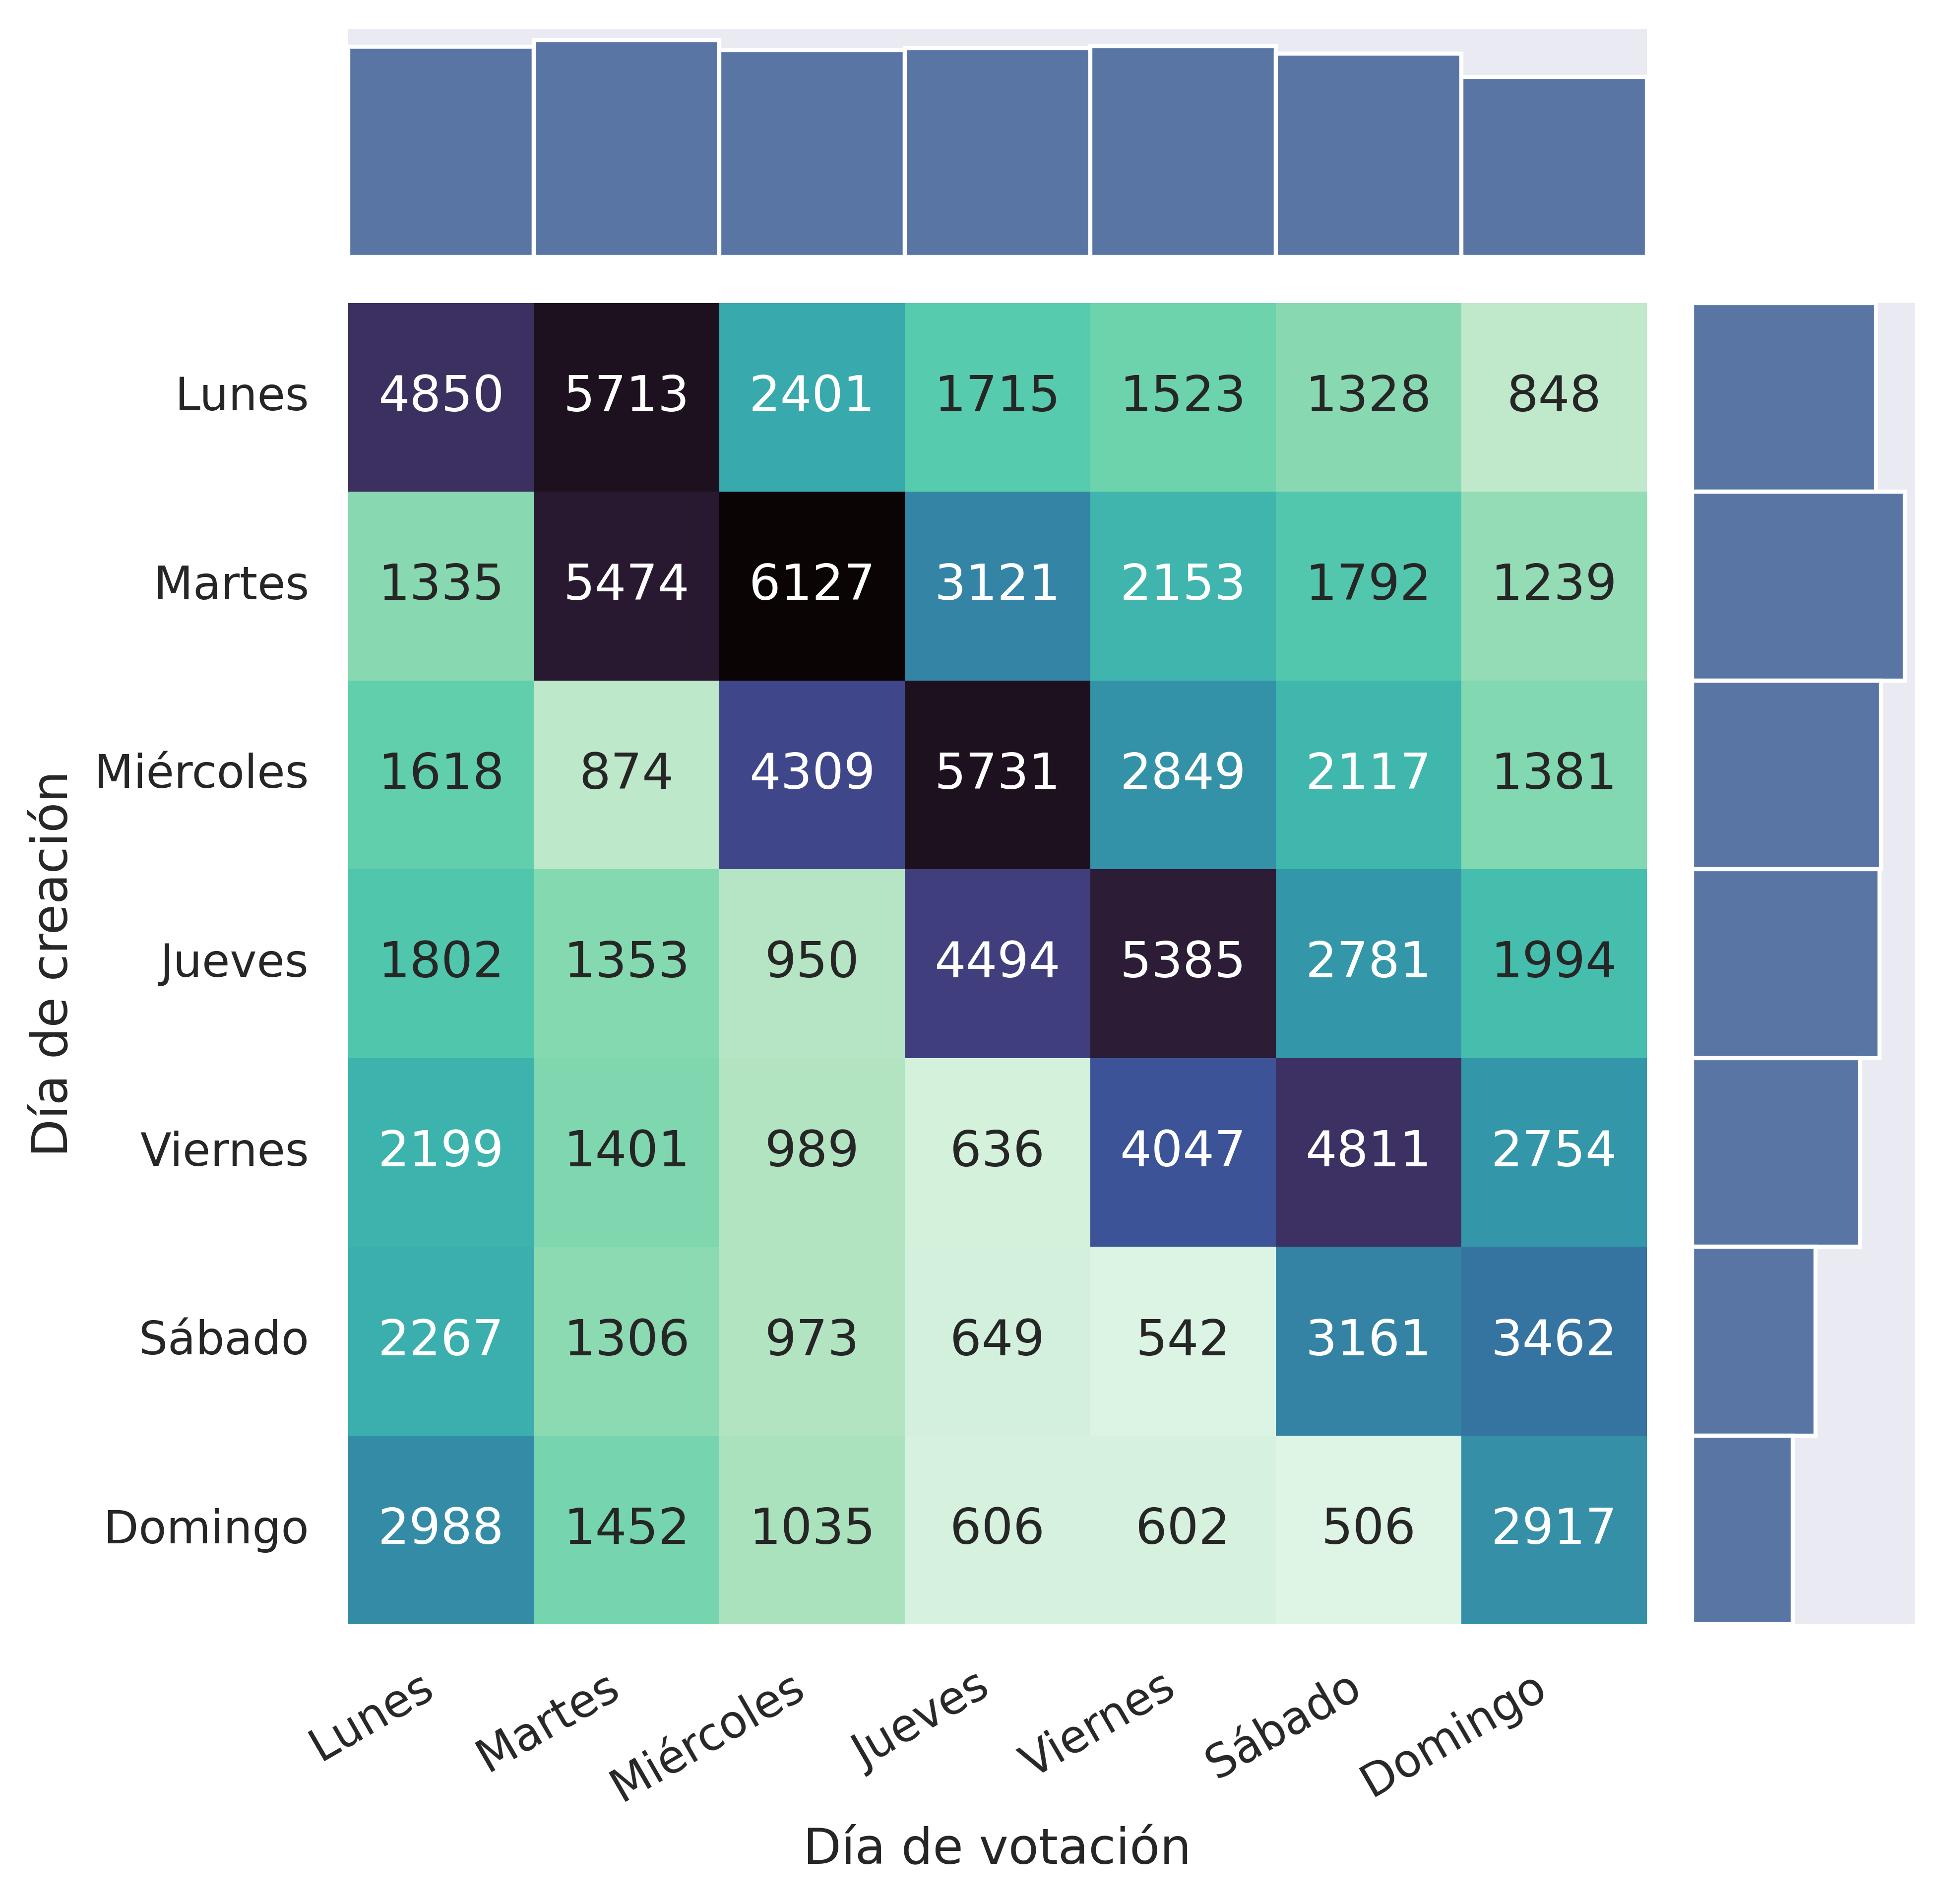

In [17]:
# _toplot = pd.crosstab(...)

grid = sns.JointGrid()

sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt='g', cmap='mako_r')
sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=1)
sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=1)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

grid.ax_joint.set_xticklabels(grid.ax_joint.get_xticklabels(), rotation=30, ha='right')
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Día de votación')
grid.ax_joint.set_ylabel('Día de creación')

nbutils.download_matplotlib(grid, f'04c_heatmap_proposals_{ORG_NAME}.pdf')

<Axes: xlabel='proposal_date_dow', ylabel='count'>

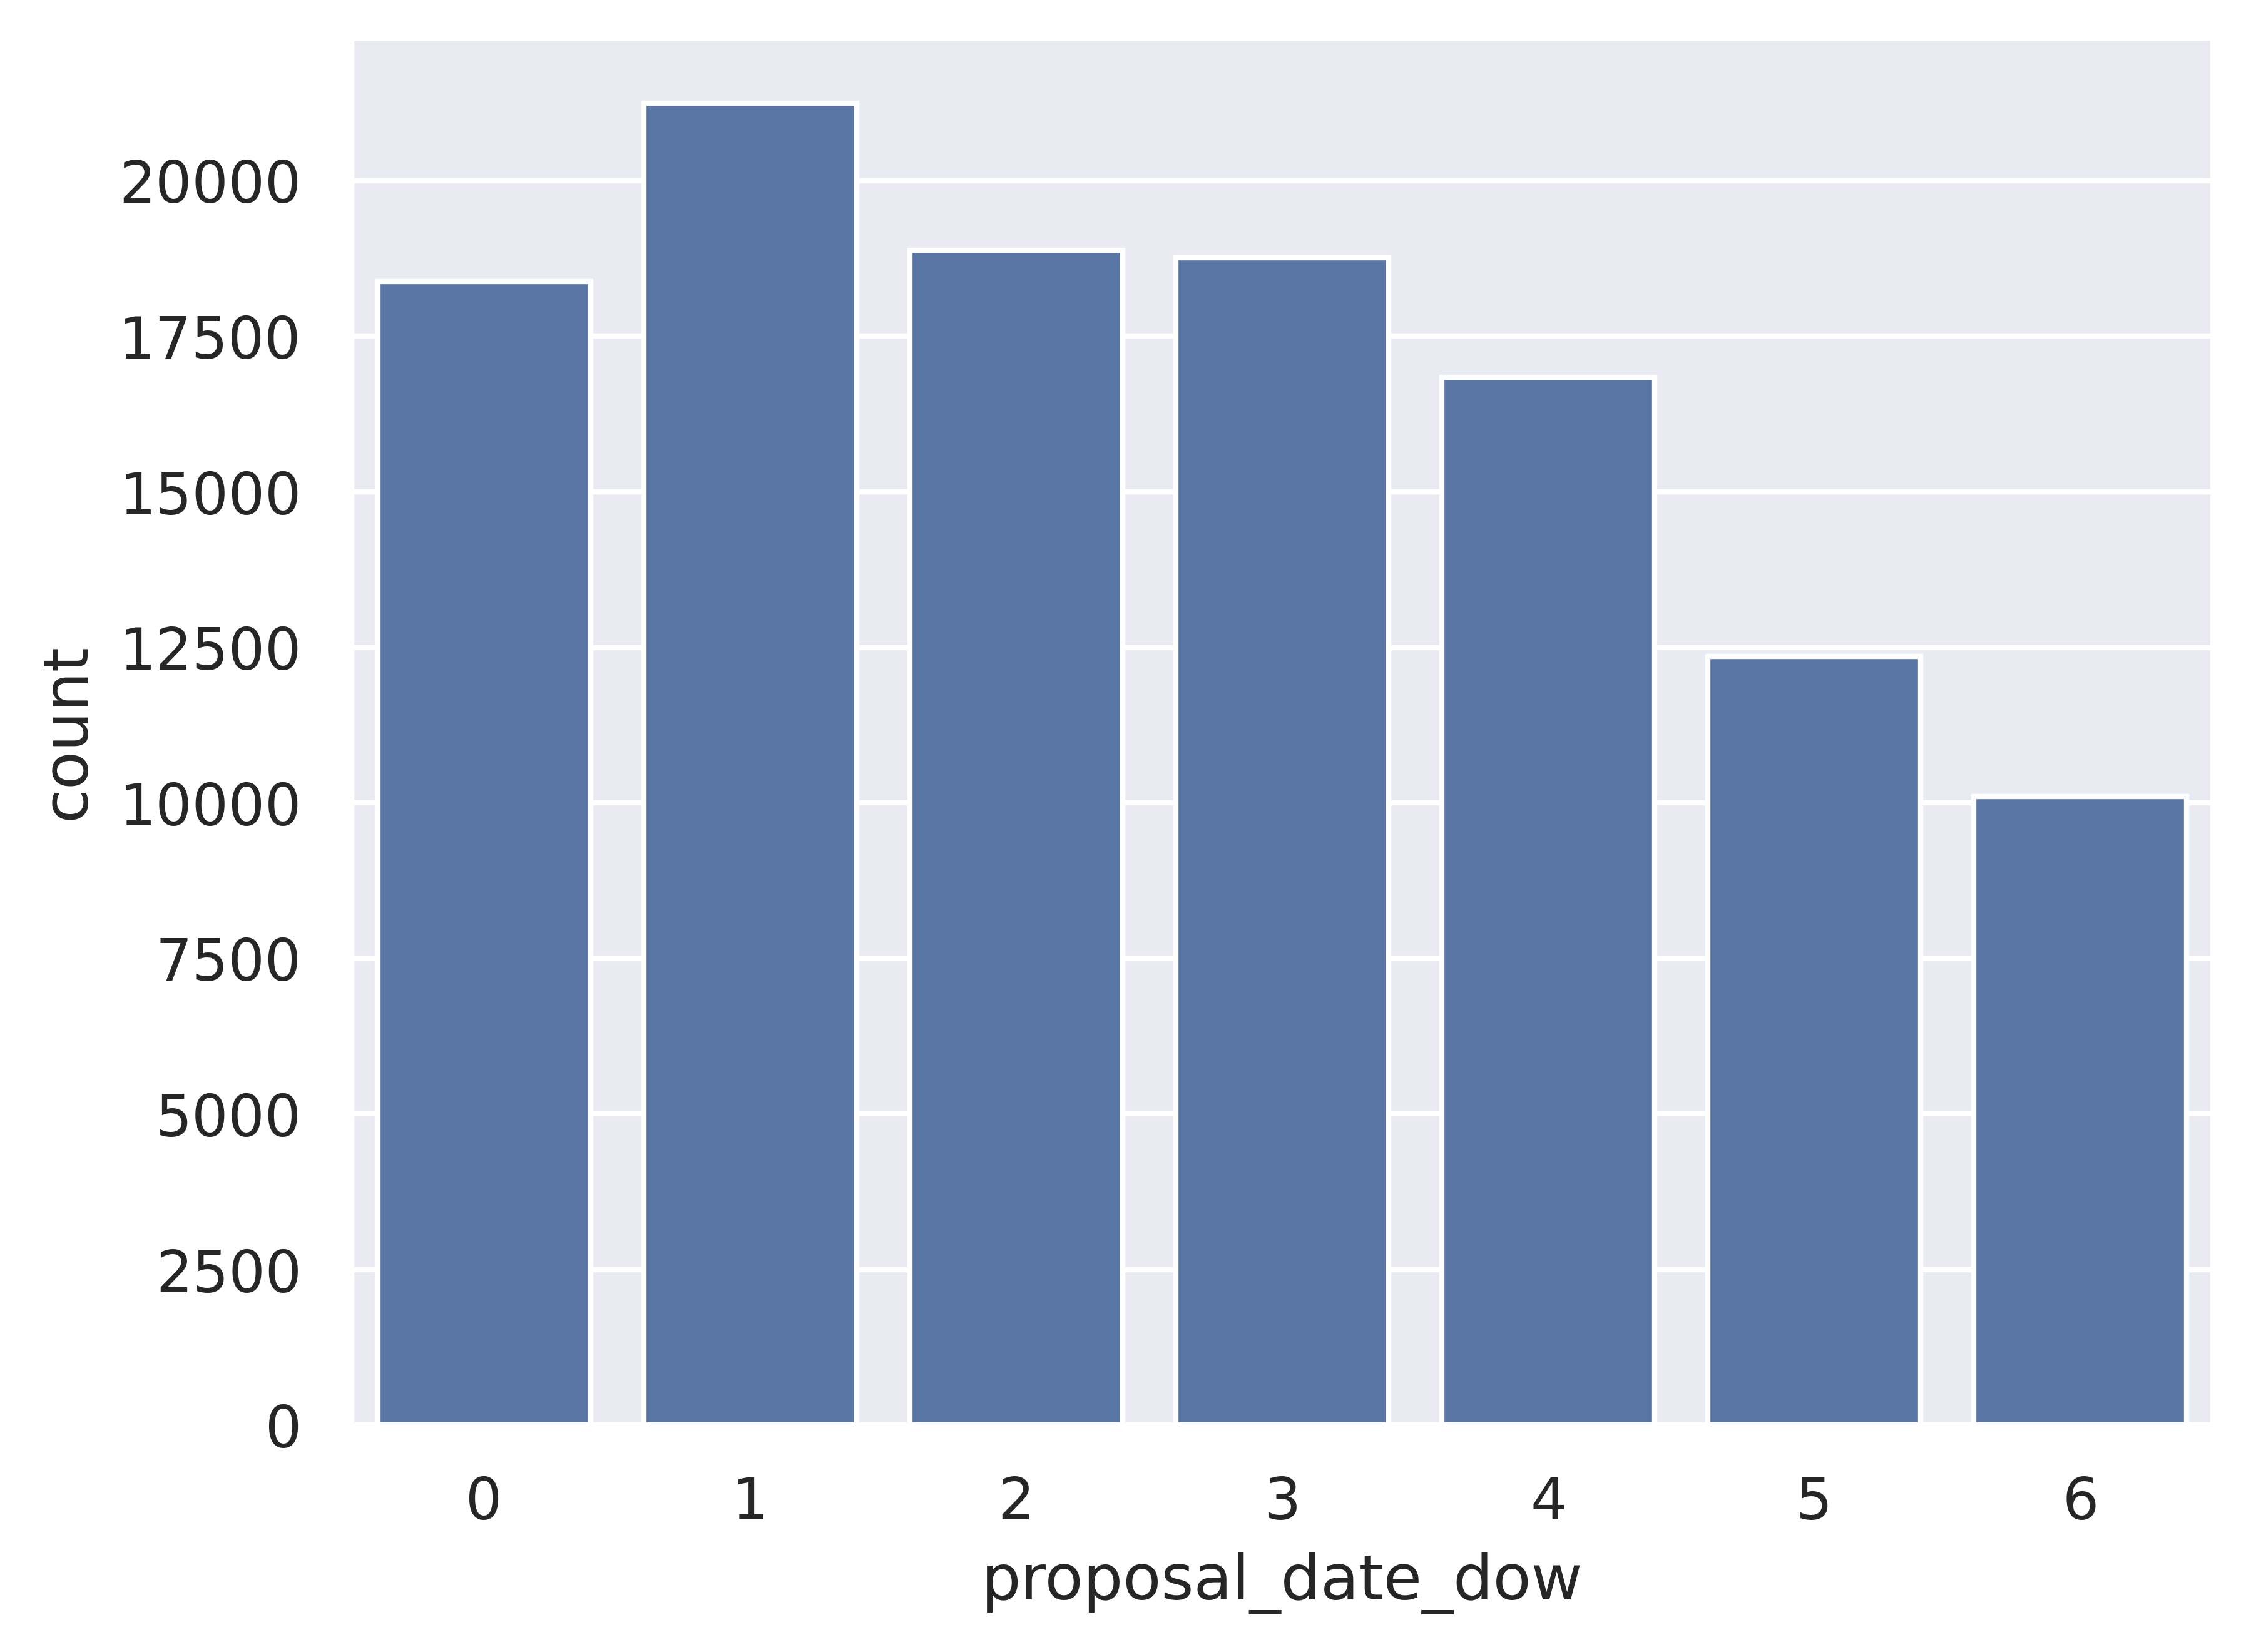

In [18]:
sns.countplot(_dfvp, x='proposal_date_dow')

<Axes: xlabel='count', ylabel='date_dow'>

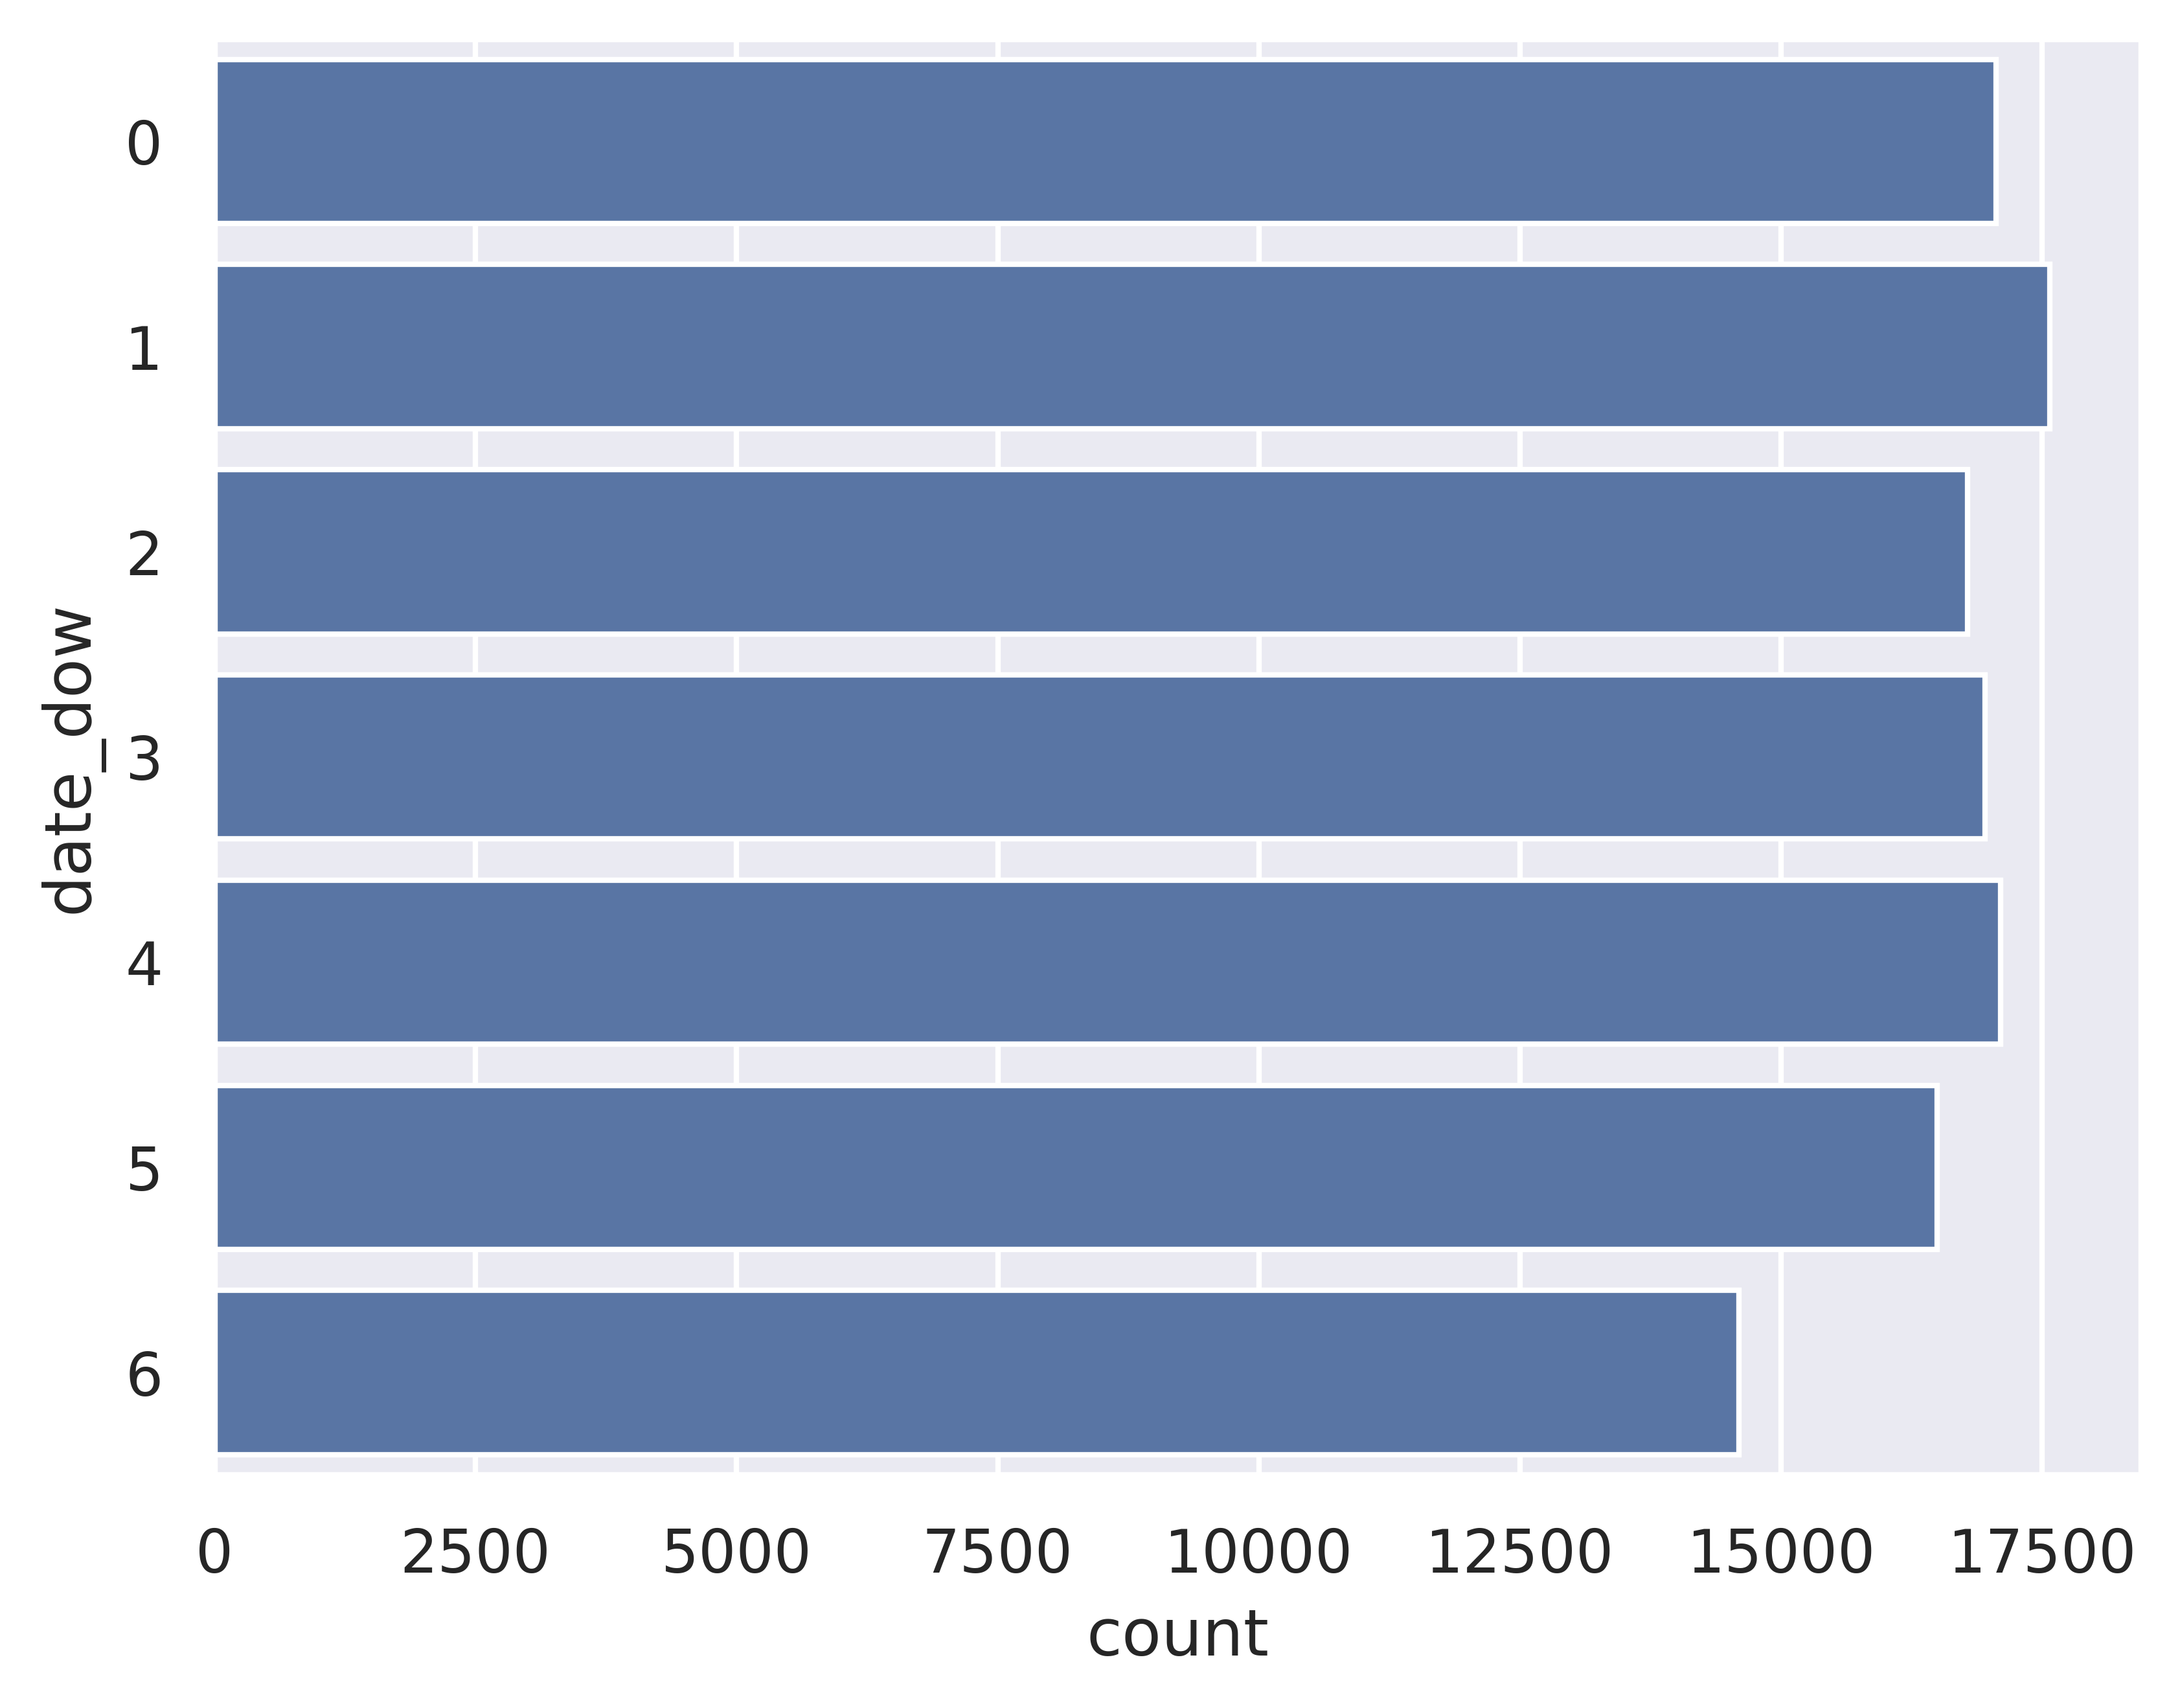

In [19]:
sns.countplot(_dfvp, y='date_dow')

## Suelen votarse las propuestas al principio o al final

In [20]:
def proposal_histogram(proposal):
    p = dfp.loc[proposal]
    _aux = dfv[dfv["proposal"] == proposal][['platform', 'name', 'date']].copy().sort_values('date')
    first_vote = p['start']
    last_vote = p['end']
    print(p['start'], p['end'], p['end'] - p['start'])
    _aux['date_rel'] = (_aux['date'] - p['start']) / (p['end'] - p['start'])
    # sns.ecdfplot(_aux['date_rel'])
    ax = sns.histplot(_aux['date_rel'])
    ax.set_title(f"Histograma de tiempo de los votos en la propuesta {proposal}")
    return ax

# proposal_histogram(proposal = "b86aa059-3d31-5d41-a472-70962816f779")

## Ahora para TODOS los votos

Cuidado que este grafo puede estar sesgado por una sola propuesta

In [21]:
dfp

platform          name  \
id                                                             
0f4784fc-022a-5047-8bfe-e16ac3bd0984  snapshot  Decentraland   
1076afc9-898c-5e2c-b935-e4098697078e  snapshot  Decentraland   
0040ba5e-10b9-500d-820d-565469375c2a  snapshot  Decentraland   
887be0e6-8878-5611-9f66-a5838dd89ee0  snapshot  Decentraland   
b6ba1508-89f8-5f1b-8b52-209f21ab8f7e  snapshot  Decentraland   
...                                        ...           ...   
4558ea33-ee07-5334-beac-707b923bb3f3  snapshot  Decentraland   
e7604960-a60b-556b-b677-5c91a78cd88f  snapshot  Decentraland   
b32ce381-23e2-538b-8ff9-33205b457c22  snapshot  Decentraland   
974d8a2c-8955-529f-96ed-061fa500bf33  snapshot  Decentraland   
629184e6-f8b2-5270-b358-252369d7599d  snapshot  Decentraland   

                                     platform_deployment  \
id                                                         
0f4784fc-022a-5047-8bfe-e16ac3bd0984    snapshot.dcl.eth   
1076afc9-898c-5e2c-b935-e4098697078e    snapshot.dcl.eth   
0040ba5e-10b9-500d-820d-565469375c2a    snapshot.dcl.eth   
887be0e6-8878-5611-9f66-a5838dd89ee0    snapshot.dcl.eth   
b6ba1508-89f8-5f1b-8b52-209f21ab8f7e    snapshot.dcl.eth   
...                                                  ...   
4558ea33-ee07-5334-beac-707b923bb3f3    snapshot.dcl.eth   
e7604960-a60b-556b-b677-5c91a78cd88f    snapshot.dcl.eth   
b32ce381-23e2-538b-8ff9-33205b457c22    snapshot.dcl.eth   
974d8a2c-8955-529f-96ed-061fa500bf33    snapshot.dcl.eth   
629184e6-f8b2-5270-b358-252369d7599d    snapshot.dcl.eth   

                                                                deployment  \
id                                                                           
0f4784fc-022a-5047-8bfe-e16ac3bd0984  41fd8de5-f8e2-5023-86a3-825c49e9ad7f   
1076afc9-898c-5e2c-b935-e4098697078e  41fd8de5-f8e2-5023-86a3-825c49e9ad7f   
0040ba5e-10b9-500d-820d-565469375c2a  41fd8de5-f8e2-5023-86a3-825c49e9ad7f   
887be0e6-8878-5611-9f66-a5838dd89ee0  41fd8de5-f8e2-5023-86a3-825c49e9ad7f   
b6ba1508-89f8-5f1b-8b52-209f21ab8f7e  41fd8de5-f8e2-5023-86a3-825c49e9ad7f   
...                                                                    ...   
4558ea33-ee07-5334-beac-707b923bb3f3  41fd8de5-f8e2-5023-86a3-825c49e9ad7f   
e7604960-a60b-556b-b677-5c91a78cd88f  41fd8de5-f8e2-5023-86a3-825c49e9ad7f   
b32ce381-23e2-538b-8ff9-33205b457c22  41fd8de5-f8e2-5023-86a3-825c49e9ad7f   
974d8a2c-8955-529f-96ed-061fa500bf33  41fd8de5-f8e2-5023-86a3-825c49e9ad7f   
629184e6-f8b2-5270-b358-252369d7599d  41fd8de5-f8e2-5023-86a3-825c49e9ad7f   

                                                                      platform_proposal  \
id                                                                                        
0f4784fc-022a-5047-8bfe-e16ac3bd0984     Qmc7rjCUjRrjQEBYL5c6oZP7AJwyjggUTUQAuBU1B8yKMT   
1076afc9-898c-5e2c-b935-e4098697078e     QmSxKNLvGWWCi1X4mc8zqueTsV1uFmAmaSooCqWg1nCQdG   
0040ba5e-10b9-500d-820d-565469375c2a     QmaG188qwu7FwneATFPH4PEKSUky43WK4zc3ETJ6RUY56V   
887be0e6-8878-5611-9f66-a5838dd89ee0     QmQDThG3LhCWCdWH4LSUAvKV5mgXzr2t3v2L1hrv4RQZQo   
b6ba1508-89f8-5f1b-8b52-209f21ab8f7e     QmTVLN8Q2ANAabyFoHU3i2SBZS3D3eZTGS4P345ysLCw2o   
...                                                                                 ...   
4558ea33-ee07-5334-beac-707b923bb3f3  0xc7ca021e5f308fbecdebc8e0cb8c3b9f61ee7947e482...   
e7604960-a60b-556b-b677-5c91a78cd88f  0xc2d2d66a6bf68d5d29b5c5c695c528cf3a89f9b44244...   
b32ce381-23e2-538b-8ff9-33205b457c22  0x96c08fae5f96cdcc7476f15e7b6b585941f7f4d25db9...   
974d8a2c-8955-529f-96ed-061fa500bf33  0x21d3a6528df036404826be2bc802783b3ca159ce9406...   
629184e6-f8b2-5270-b358-252369d7599d  0xd19753447672ea6d3445c12b7c7d876a07243f104057...   

                                                                          author  \
id                                                                                 
0f4784fc-022a-5047-8bfe-e16ac3bd0984  0x5e23d08324f017d54

Text(0.5, 1.0, 'Histograma de todos los votos realizados en Decentraland')

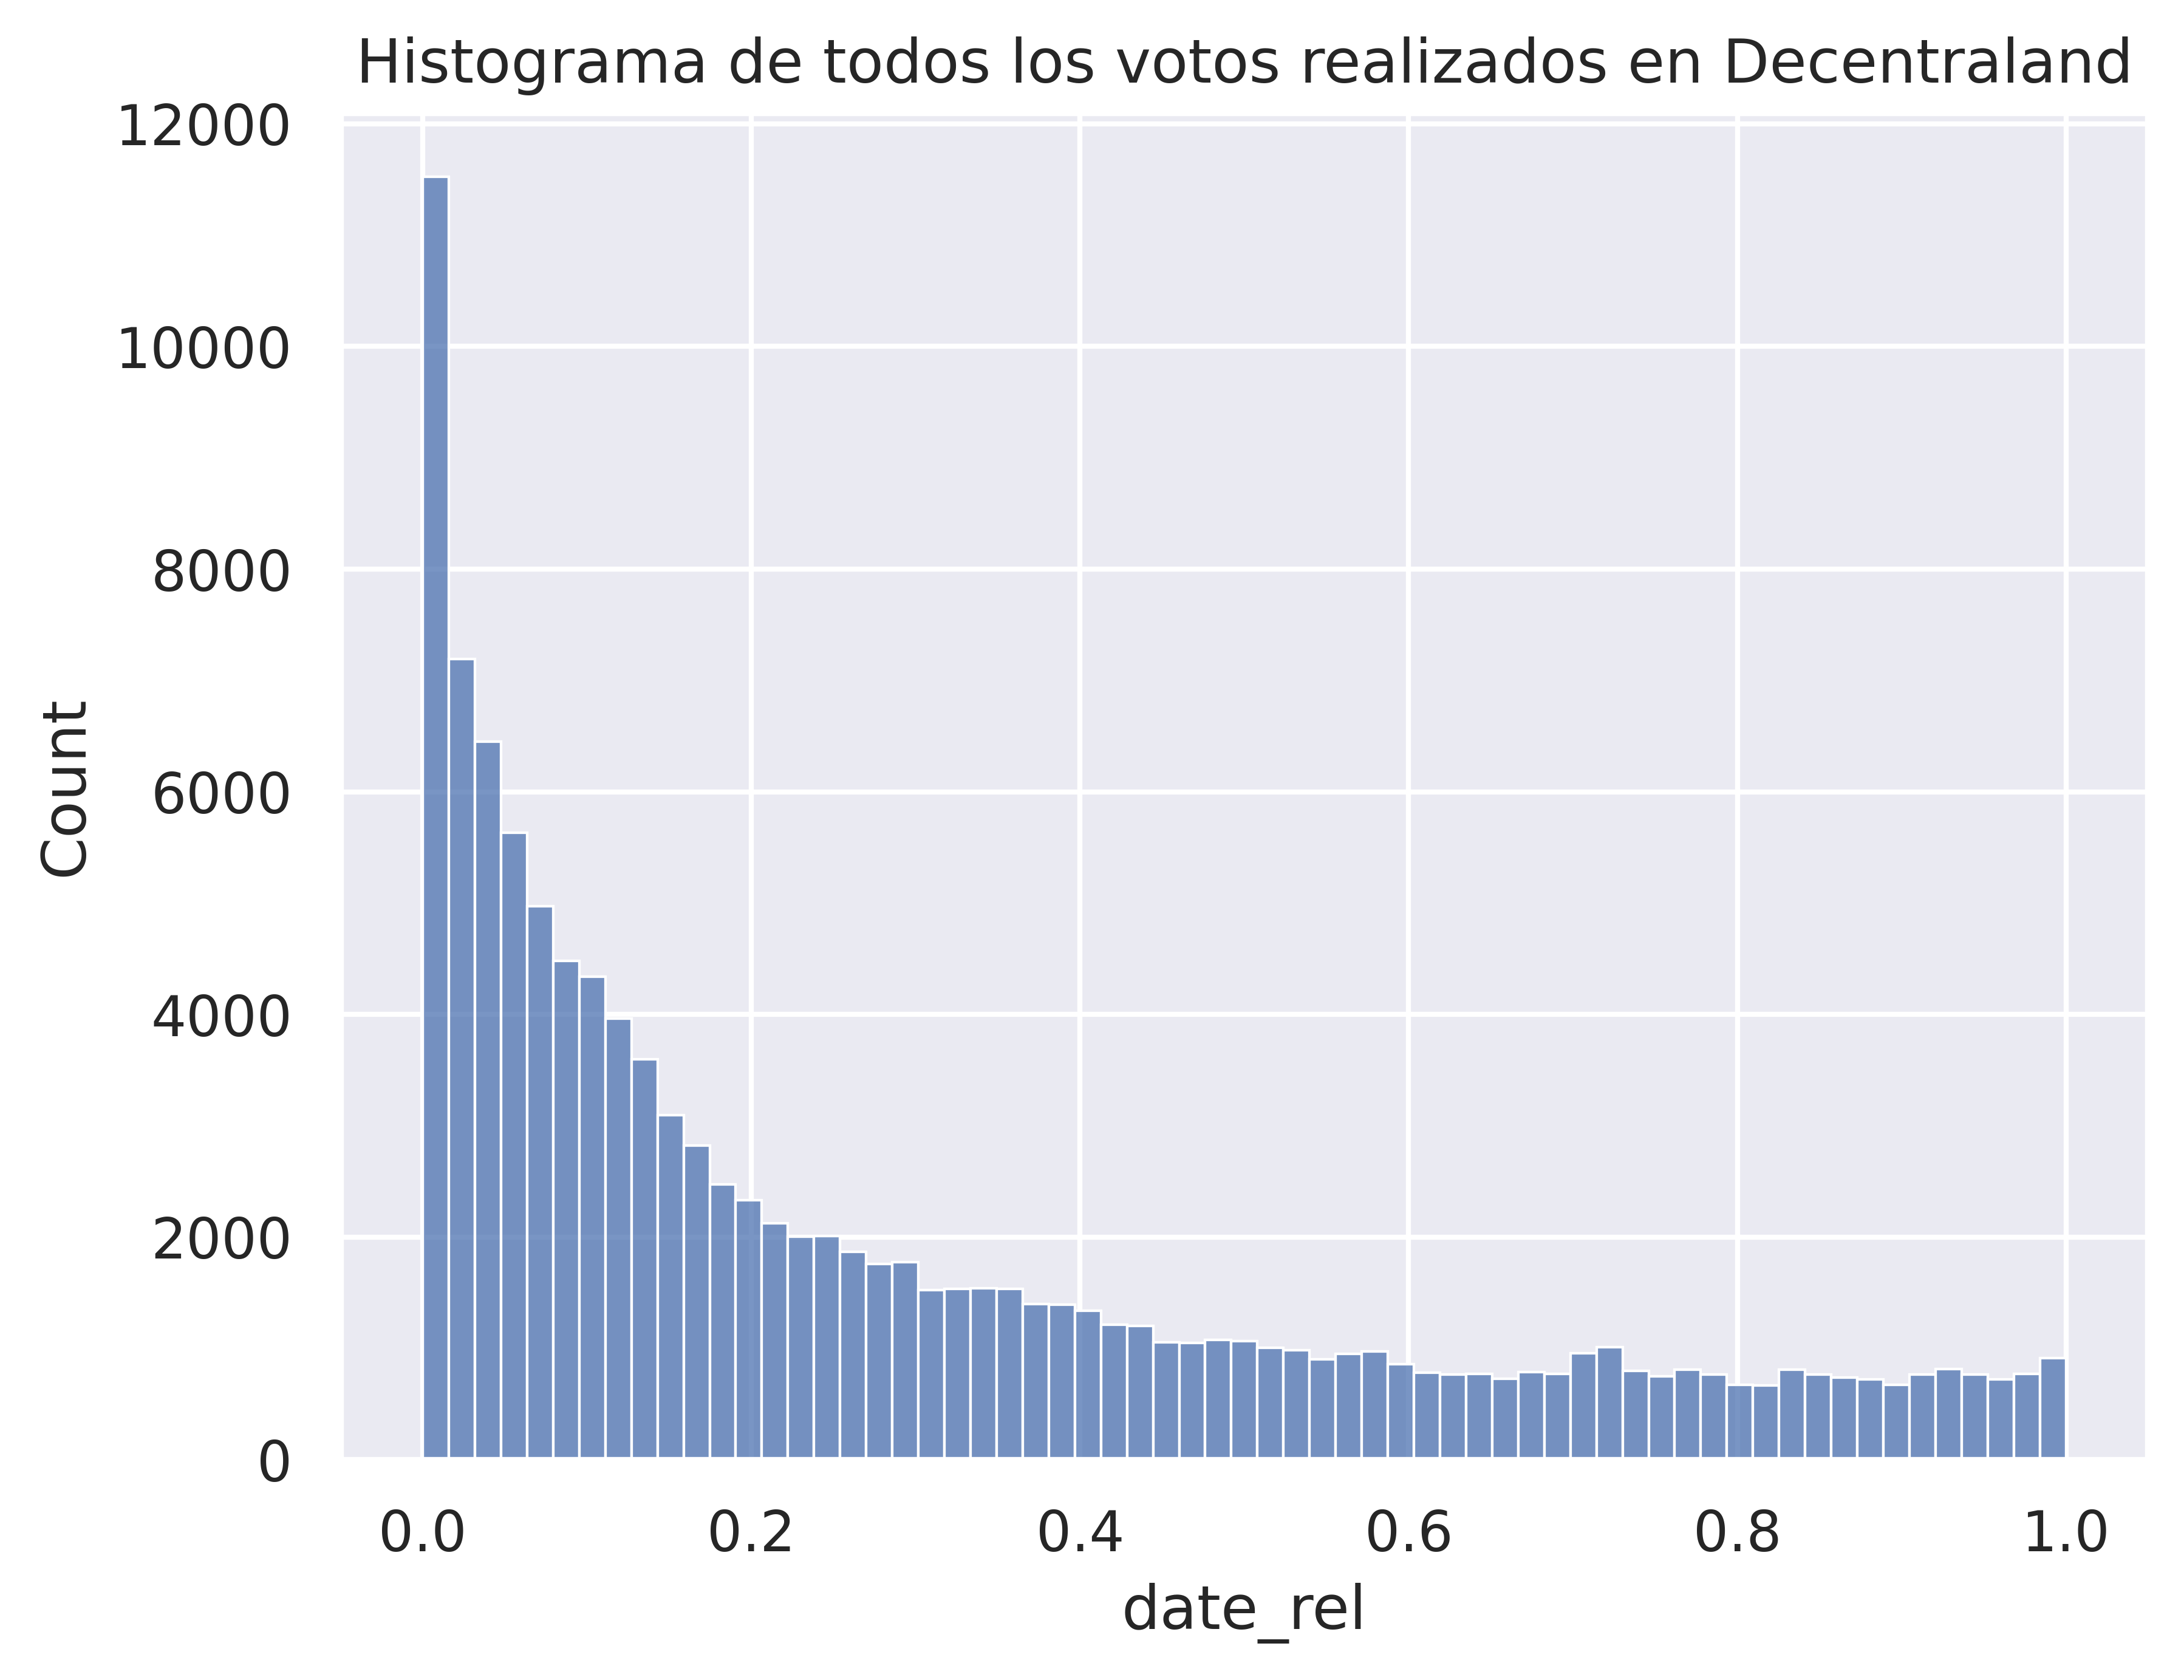

In [22]:
_dfv = dfv[['platform', 'name', 'proposal', 'date']].merge(dfp[['start', 'end']], left_on='proposal', right_index=True).sort_values('date')
_dfv['date_rel'] = (_dfv['date'] - _dfv['start']) / (_dfv['end'] - _dfv['start'])
ax = sns.histplot(_dfv, x='date_rel')
ax.set_title(f"Histograma de todos los votos realizados en {ORG_NAME}")

In [23]:
_dfv[['date_rel']].describe(percentiles=[.1,.25,.5,.75,.78,.8])

date_rel
count  116560.000000
mean        0.284883
std         0.279415
min         0.000008
10%         0.016169
25%         0.058511
50%         0.175888
75%         0.449425
78%         0.501090
80%         0.538141
max         0.999993

### Cuando son los votos (histograma distribución en tiempo de TODOS los votos)

Vamos a intentar calcular la frecuencia relativa acumulada

In [24]:
rel = (1 / _dfv.groupby('proposal').size()).rename('freq')
_dfv2 = _dfv.join(rel, on='proposal')
_dfv2['cumfreq'] = _dfv2.groupby('proposal')['freq'].cumsum()
_dfv2

platform          name                              proposal  \
10527  snapshot  Decentraland  312c5654-0806-5473-8243-dbd6311208ed   
31518  snapshot  Decentraland  f6bd4c7d-0d1e-5437-9cf9-e5e883522d3f   
69100  snapshot  Decentraland  2dc28092-bb92-5c3f-8837-f8ed570d1a20   
69099  snapshot  Decentraland  2dc28092-bb92-5c3f-8837-f8ed570d1a20   
37507  snapshot  Decentraland  94c28bf3-501e-5925-98a3-b4ddbed07abf   
...         ...           ...                                   ...   
69192  snapshot  Decentraland  e5fcfaed-fd89-547f-aba0-b682b2114a4b   
72239  snapshot  Decentraland  f41ed318-2f75-5a16-a798-6623e99fb55a   
57127  snapshot  Decentraland  858339c3-6902-52c5-ab98-bb5985327cbd   
72238  snapshot  Decentraland  f41ed318-2f75-5a16-a798-6623e99fb55a   
69191  snapshot  Decentraland  e5fcfaed-fd89-547f-aba0-b682b2114a4b   

                     date               start                 end  date_rel  \
10527 2021-05-24 15:29:29 2021-05-24 15:29:00 2021-05-31 15:29:00  0.000048   
31518 2021-05-24 15:30:54 2021-05-24 15:30:00 2021-05-31 15:30:00  0.000089   
69100 2021-05-24 15:38:54 2021-05-24 15:38:00 2021-05-31 15:38:00  0.000089   
69099 2021-05-24 15:41:31 2021-05-24 15:38:00 2021-05-31 15:38:00  0.000349   
37507 2021-05-24 15:50:36 2021-05-24 15:49:00 2021-05-31 15:49:00  0.000159   
...                   ...                 ...                 ...       ...   
69192 2023-07-19 16:19:59 2023-07-06 15:59:00 2023-07-20 15:59:00  0.929612   
72239 2023-07-19 17:54:31 2023-07-06 15:28:00 2023-07-20 15:28:00  0.935839   
57127 2023-07-19 17:57:35 2023-07-06 15:12:00 2023-07-20 15:12:00  0.936785   
72238 2023-07-20 00:56:09 2023-07-06 15:28:00 2023-07-20 15:28:00  0.956753   
69191 2023-07-20 15:42:01 2023-07-06 15:59:00 2023-07-20 15:59:00  0.999158   

           freq   cumfreq  
10527  0.058824  0.058824  
31518  0.045455  0.045455  
69100  0.038462  0.038462  
69099  0.038462  0.076923  
37507  0.050000  0.050000  
...         ...       ...  
69192  0.006849  0.993151  
72239  0.008772  0.991228  
57127  0.006944  1.000000  
72238  0.008772  1.000000  
69191  0.006849  1.000000  

[116560 rows x 9 columns]

In [25]:
_dfv2.groupby('proposal').size().sort_values()

proposal
0eba85b3-4b75-57a8-a39f-c03cdb3d4ceb      1
c1cedeb2-d73a-58d8-83ba-52e664bcfd9a      1
4e9eb42b-a392-5846-be0a-5d1c9701a590      1
b6496db6-6d33-5340-a3a2-c55fa6d9fd95      1
383875d0-0791-5d8c-8abb-5861aa072a29      1
                                       ... 
6a88aec3-b179-56da-b9c0-d7072299b987    344
5ba291bd-b9e5-526f-82ab-9e55ce1d297c    365
ef768acf-0eb6-56a6-9d94-bfc6422deb83    372
b32ce381-23e2-538b-8ff9-33205b457c22    382
433b7e43-77b0-5ea1-bac3-0c3071363a56    385
Length: 1942, dtype: int64


### KDE plot de las más votadas

/tmp/ipykernel_180422/2348142249.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(_toplot, x='date_rel', hue='proposal', legend=False).set_title(f"kde plot de las 15 propuestas más grandes en {ORG_NAME}")


Text(0.5, 1.0, 'kde plot de las 15 propuestas más grandes en Decentraland')

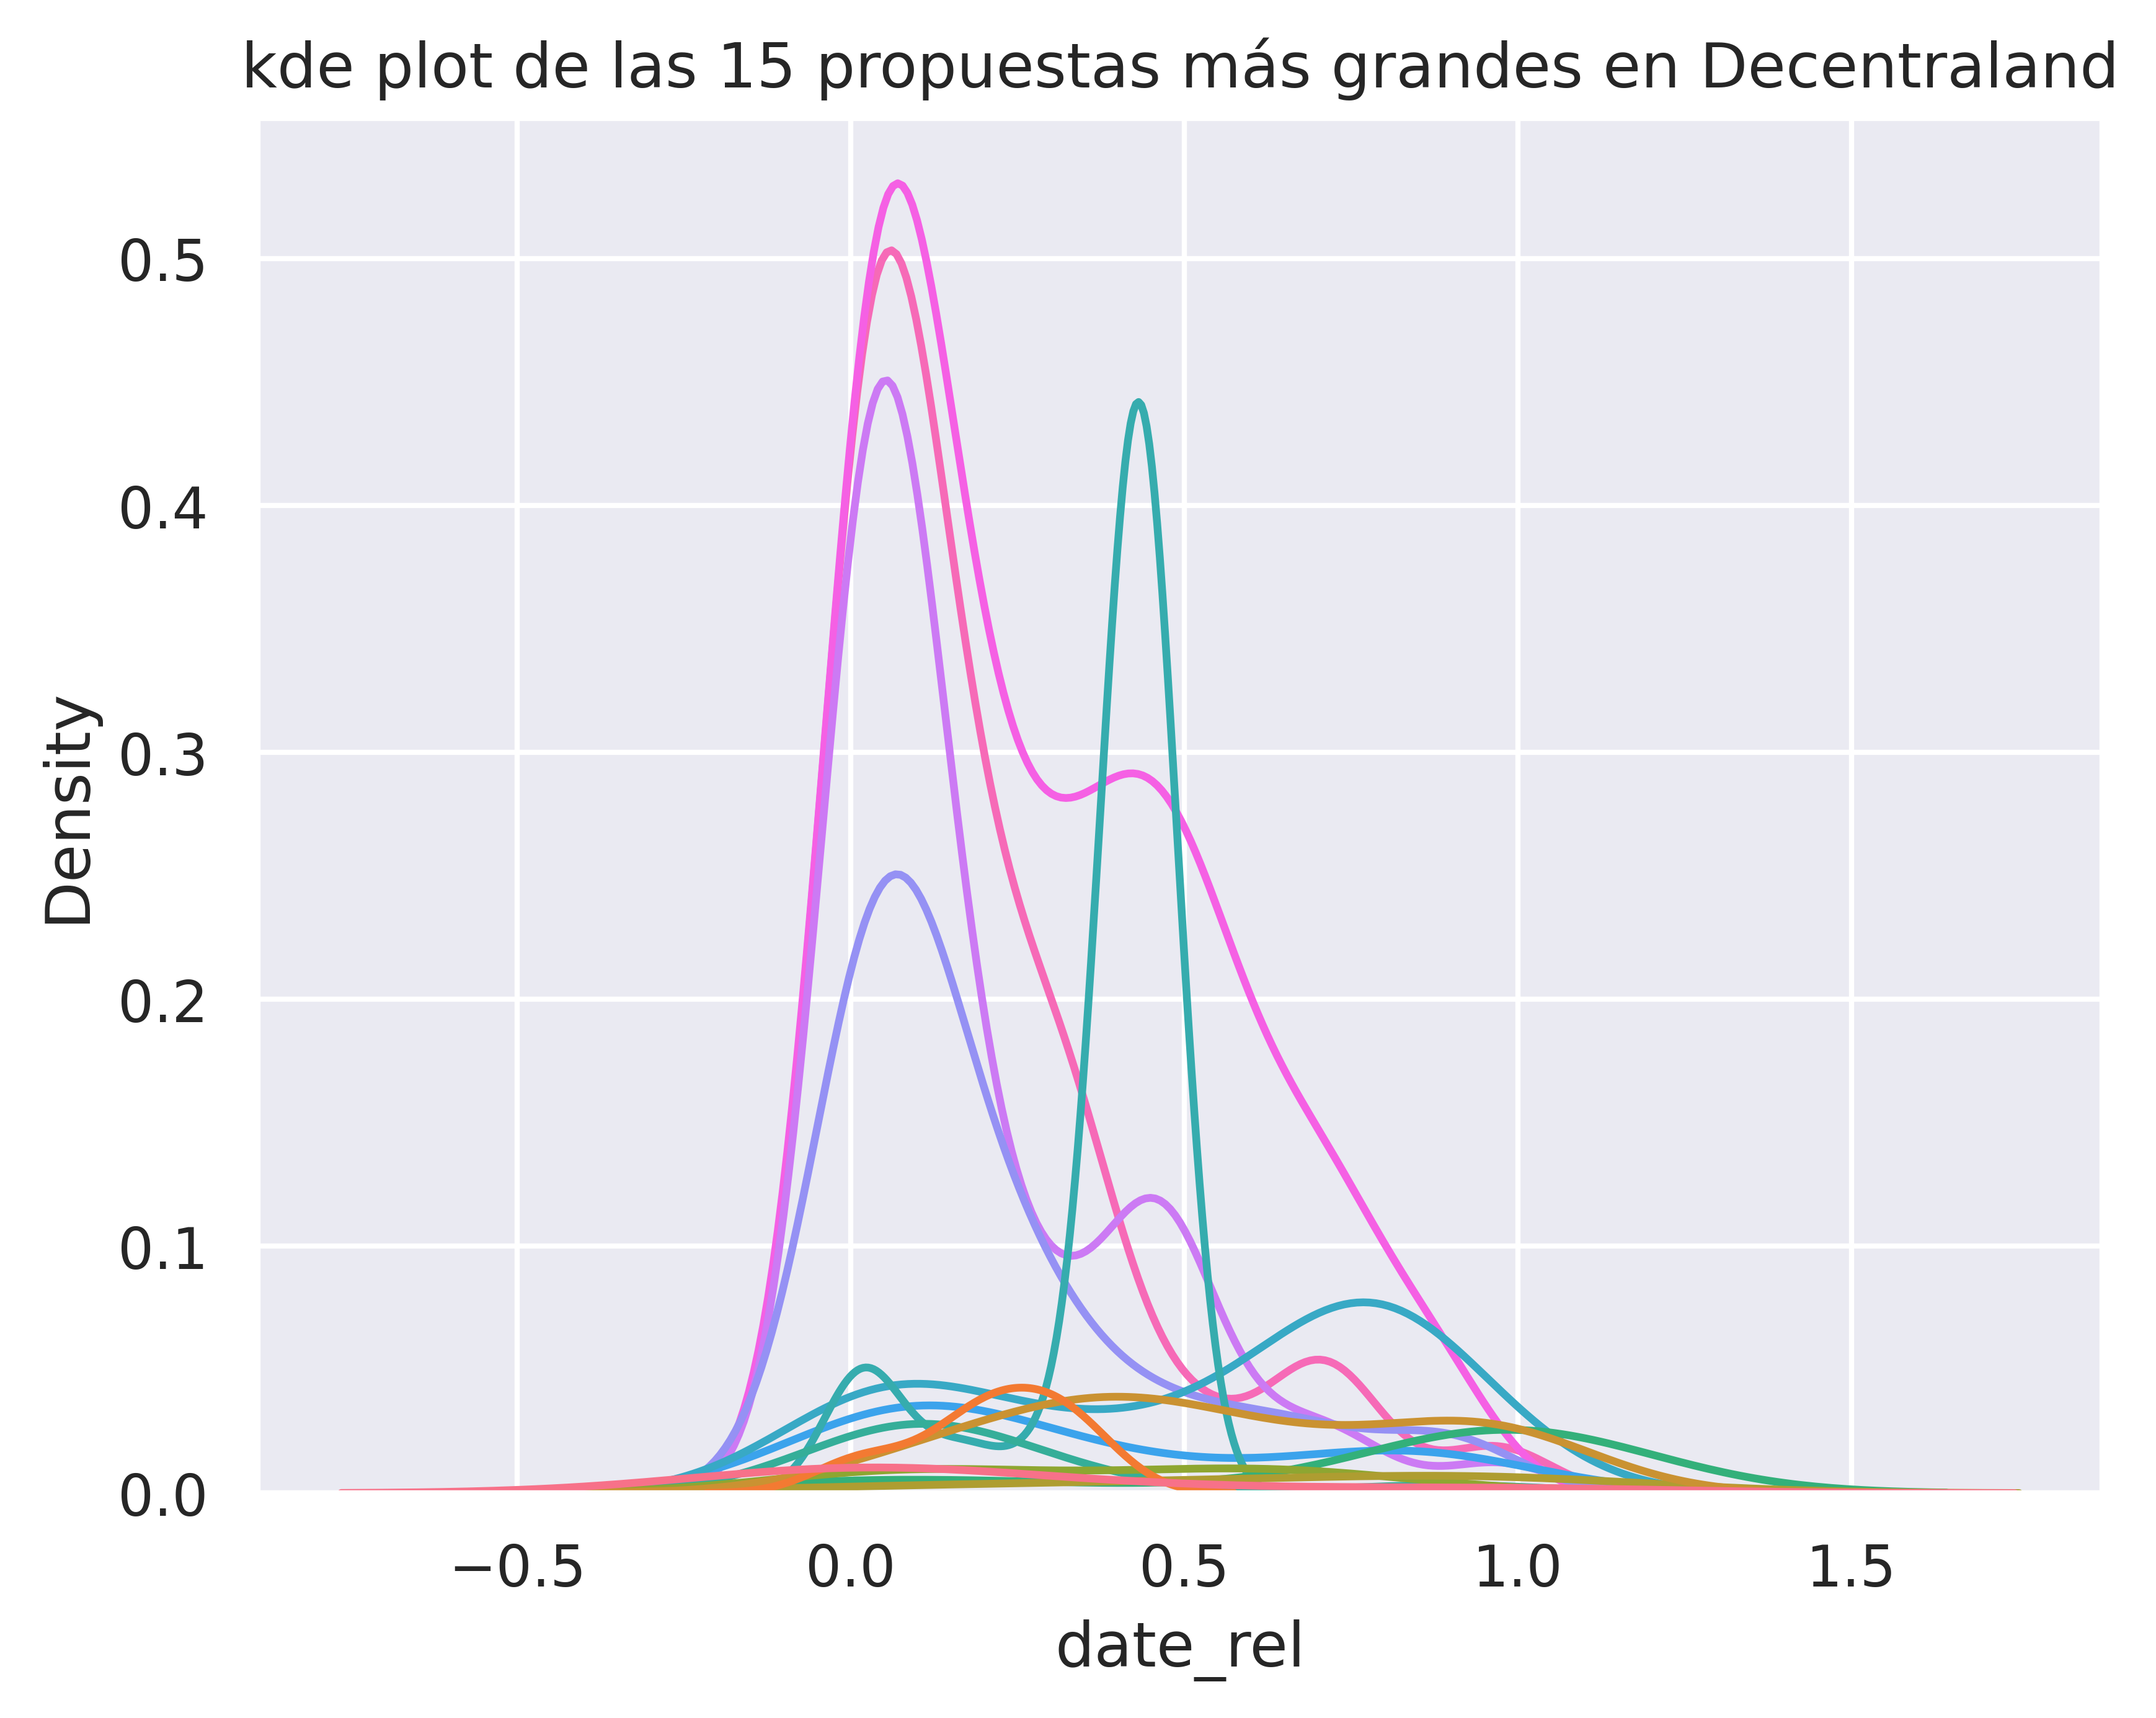

In [26]:
# Get N random proposals
# proposals = np.random.choice(_dfv2['proposal'].unique(), 15, replace=False, p=_dfv2.groupby('proposal').size() / _dfv2.groupby('proposal').size().sum())

# Get top N proposals
proposals = _dfv2.groupby('proposal').size().tail(15).index

_toplot = _dfv2[_dfv2['proposal'].isin(proposals)].copy()
_toplot['proposal'] = _toplot['proposal'].astype(str)
assert _toplot['proposal'].nunique() == len(proposals)
sns.kdeplot(_toplot, x='date_rel', hue='proposal', legend=False).set_title(f"kde plot de las 15 propuestas más grandes en {ORG_NAME}")

Efectivamente, los votos se realizan sobre todo nada más crearse la propuesta. El 25% de los votos ya han sido emitidos cuando aún queda un 95% del tiempo restante, y solo un 22% votan en la segunda mitad del tiempo disponible. Sin embargo, como podemos observar en la figura de `[kde plot de las 15 propuestas más grandes]`, hay propuestas en las que al final puede haber un pequeño repunte de actividad. Recordemos que en las DAOs el resultado de la votación es siempre visible, lo que puede sesgar la participación si los usuarios piensan que el resultado es estable y no va a cambiar.

Al partir el dataset en puntos aleatorios considerando una distribución uniforme, lo más seguro es que nos encontremos que las propuestas con las que entrenamos y testeamos (las _frontera_), tengan, en general más votos en el conjunto de entrenamiento que en el de test. Por esta razón también es necesario un sistema que sea muy resiliente al problema de cold start.